1


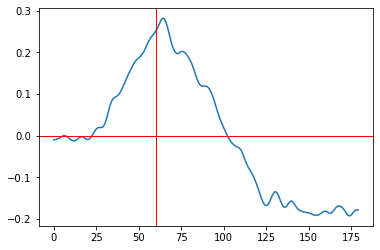

2


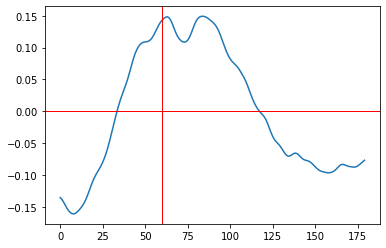

3


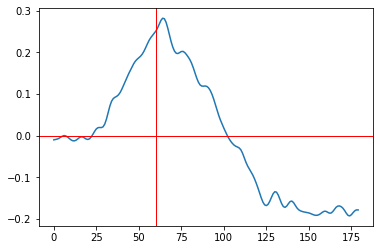

4


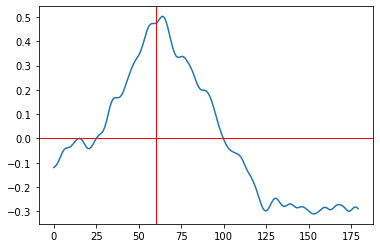

5


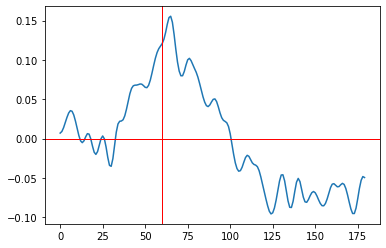

6


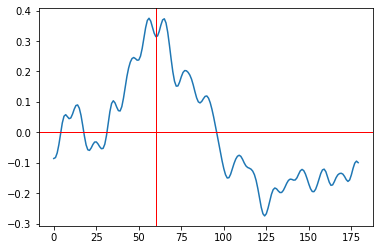

7


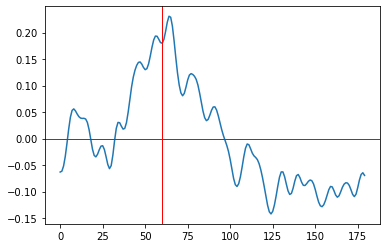

(210, 7, 180)
(210, 7, 180)


In [1]:
## train의 test값을 저장 한다. 
import hdf5storage
import numpy as np
from scipy.signal import butter, lfilter
import os
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
def Re_referencing(eegData, channelNum, sampleNum):
        after_car = np.zeros((channelNum,sampleNum))
        for i in np.arange(channelNum):
            after_car[i,:] = eegData[i,:] - np.mean(eegData,axis=0)
        return after_car
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y

def Epoching(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
        return [Epochs, Num[0]]

def Convert_to_featureVector(EpochsT, NumT, EpochsN, NumN, featureNum):
        FeaturesT = np.zeros((NumT, featureNum))
        for i in range(NumT):
            FeaturesT[i,:] = np.reshape(EpochsT[i,:,:],(1,featureNum))
        FeaturesN = np.zeros((NumN, featureNum))
        for j in range(NumN):
            FeaturesN[j,:] = np.reshape(EpochsN[j,:,:],(1,featureNum))
        return [FeaturesT,FeaturesN]

def Balancing_DataSet(Epochs, size):
        Epochs_New = np.zeros((size, Epochs.shape[1], Epochs.shape[2]))
    
        index = np.random.choice(Epochs.shape[0], size = size, replace = False)
    
        Epochs_New = Epochs[index, :, :]
    
        return Epochs_New
    
def baseline_correction(Epochs):
    for i in range(Epochs.shape[1]):
        for j in range(Epochs.shape[0]):
            Epochs[j,i,:] = np.subtract(Epochs[j,i,:], np.mean(Epochs[j,i,:]))
    
    return Epochs
        
def Standardization(Epochs):
        for i in range(Epochs.shape[1]):
            Epochs[:,i,:] = np.subtract(Epochs[:,i,:], np.mean(Epochs[:,i,:]))
            Epochs[:,i,:] = Epochs[:,i,:] / np.std(Epochs[:,i,:])
    
        return Epochs

def Make_Average_Component(EpochsT, NumT, EpochsN, NumN, channelNum, epochSampleNum, componentNum):
        EpochsT = baseline_correction(EpochsT)
        EpochsN = baseline_correction(EpochsN)
        NumT_Aver = NumT-componentNum
        NumN_Aver = NumN-componentNum
    
        EpochsT_Aver = np.zeros((NumT_Aver, channelNum, epochSampleNum))
        EpochsN_Aver = np.zeros((NumN_Aver, channelNum, epochSampleNum))
        for i in range(NumT_Aver):
            EpochsT_Aver[i, :, :] = np.mean(EpochsT[i:i+componentNum, :, :], axis=0)
        for j in range(NumN_Aver):
            EpochsN_Aver[j, :, :] = np.mean(EpochsN[j:j+componentNum, :, :], axis=0)
        
        return [EpochsT_Aver, NumT_Aver, EpochsN_Aver, NumN_Aver]

def plotGraph(filename):


        mat = hdf5storage.loadmat(filename)
        channelNames = mat['channelNames']
        eegData = mat['eegData']
        samplingFreq = mat['samplingFreq']
        samplingFreq = samplingFreq[0,0]
        stims = mat['stims']
        channelNum = channelNames.shape
        channelNum = channelNum[1]
        eegData = np.transpose(eegData)
        
        ##Preprocessing process
        #eegData = Re_referencing(eegData, channelNum, eegData.shape[1])
        
        #Bandpass Filter
        eegData = butter_bandpass_filter(eegData, 0.23, 30, samplingFreq, order=4)
    
        #Epoching
        epochSampleNum = int(np.floor(0.6 * samplingFreq))
        offset = int(np.floor(0.2 * samplingFreq)) 
        baseline = int(np.floor(0.8 * samplingFreq)) 
        [EpochsT, NumT] = Epoching(eegData, stims, 1, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        [EpochsN, NumN] = Epoching(eegData, stims, 0, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        
        EpochsN_New = Balancing_DataSet(EpochsN, NumT)
        
        #Convert to feature vector
        #[EpochsT, NumT_Aver, EpochsN, NumN_Aver] = Make_Average_Component(EpochsT, NumT, EpochsN_New, NumT, channelNum, epochSampleNum, 20)
        EpochsT = Standardization(EpochsT)
        EpochsN = Standardization(EpochsN_New)
        Target_All=np.mean(EpochsT,axis=0)
        for k in np.arange(0,7):
            a=k+1
            print(a)
            plt.plot(Target_All[k,:])
            plt.axvline(x=60, color='r', linewidth=1)
            plt.axhline(y=0, color='r', linewidth=1)
            plt.show()          
        return [EpochsT[:,:,:], EpochsN[:,:,:]]


def main():
    root = '/Users/eunice/Desktop/Desktop/실험데이터/S19/Training/mat/Training-[2020.11.17-20.15.41].mat'
    hz=180
    T_all= np.zeros((210,7,hz))
    N_all= np.zeros((210,7,hz))

    [T_all[:,:,:],N_all[:,:,:]]=plotGraph(root)
    mat_file = io.loadmat(root)
    
    target_data = T_all
    non_target_data = N_all

    print(target_data.shape)
    print(non_target_data.shape)
#-----------------------------------------
    output_file = "./resampled_data_test.npz"
    np.savez(output_file, np.array(target_data,dtype=float), np.array(non_target_data,dtype=float))
#-------------------------------------

    
if __name__ == "__main__":
    main()

subject 1 is preprocessed
subject 2 is preprocessed
subject 3 is preprocessed
subject 4 is preprocessed
subject 5 is preprocessed
subject 7 is preprocessed
subject 8 is preprocessed
subject 9 is preprocessed
subject 10 is preprocessed
subject 11 is preprocessed
subject 12 is preprocessed
subject 13 is preprocessed
subject 14 is preprocessed
subject 15 is preprocessed
subject 16 is preprocessed
subject 17 is preprocessed
subject 18 is preprocessed
subject 19 is preprocessed
subject 20 is preprocessed
subject 21 is preprocessed
subject 22 is preprocessed
subject 23 is preprocessed
subject 24 is preprocessed
subject 26 is preprocessed
subject 27 is preprocessed
subject 28 is preprocessed
subject 29 is preprocessed
subject 30 is preprocessed
subject 31 is preprocessed
subject 32 is preprocessed
subject 33 is preprocessed
subject 34 is preprocessed
subject 35 is preprocessed
subject 36 is preprocessed
subject 37 is preprocessed
subject 39 is preprocessed
subject 40 is preprocessed
subject 4

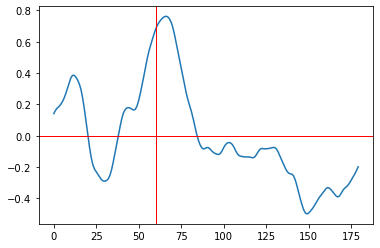

2


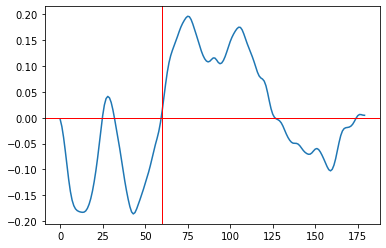

3


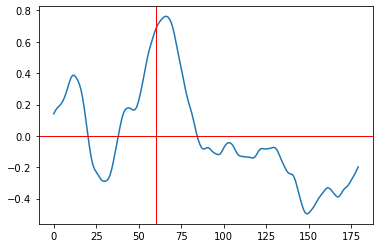

4


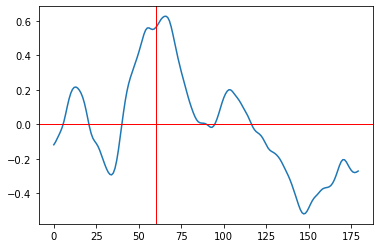

5


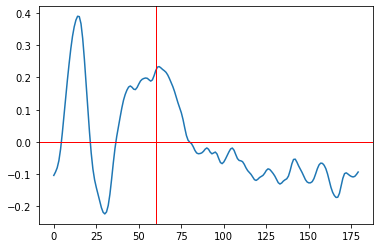

6


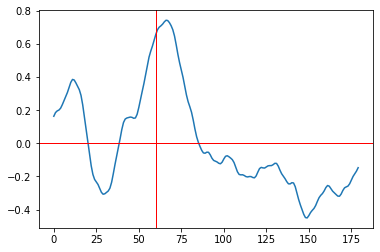

7


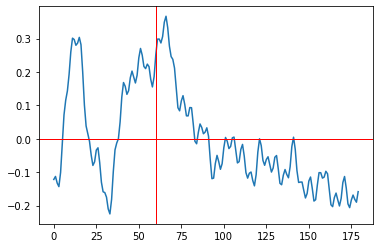

start:
51
finish:
231
0.7618332908353002
0.11624214694908319


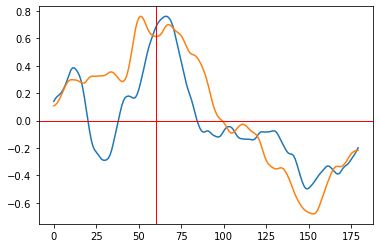

start:
7
finish:
187
0.19646603006323987
0.24366771120638958


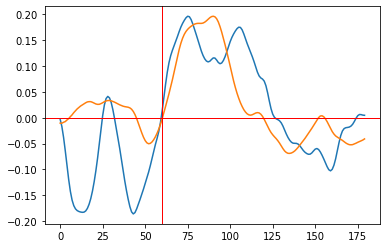

start:
26
finish:
206
0.7626685306318673
0.34203717679990353


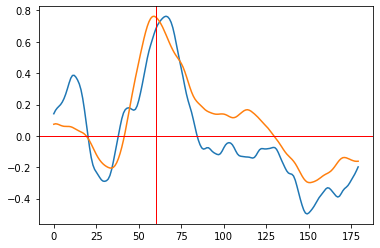

start:
29
finish:
209
0.6259504314942678
0.11080449819656192


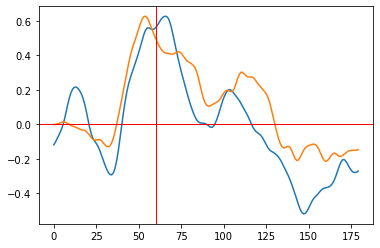

start:
29
finish:
209
inverse
0.3898755391712189
0.34086332629346605


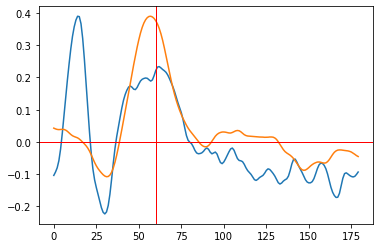

start:
30
finish:
210
inverse
0.7427139740091713
0.20063245670399843


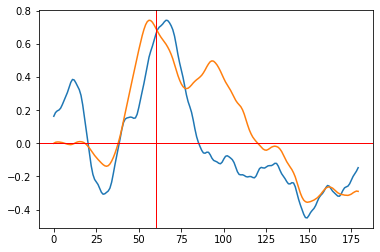

start:
33
finish:
213
inverse
0.3671380150723123
0.42624276277906964


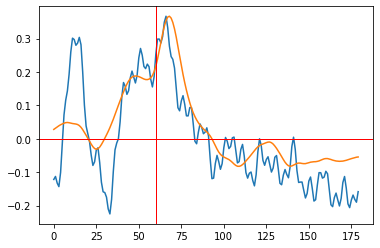

(11340, 7, 180)
(11340, 7, 180)
1


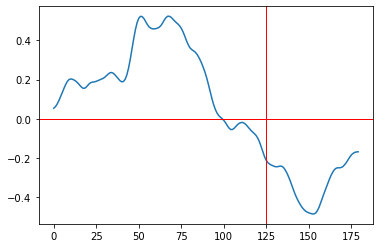

2


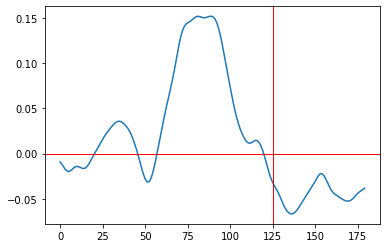

3


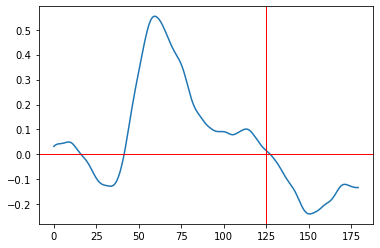

4


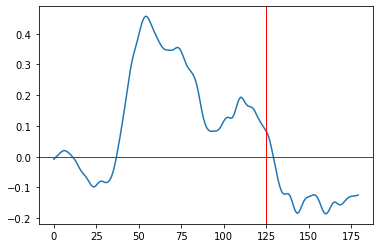

5


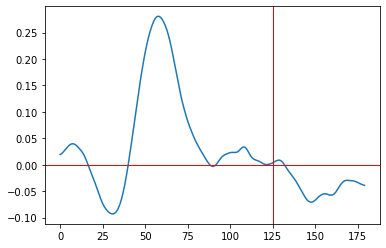

6


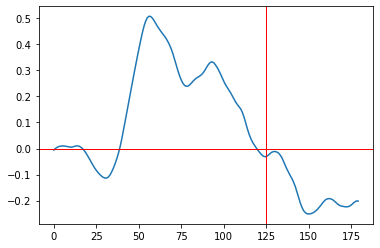

7


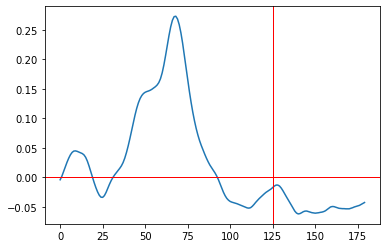

In [57]:
# DataProcessing and model generation process
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import hdf5storage
import numpy as np
from scipy.signal import butter, lfilter
import os,glob
from scipy import signal
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline

def Re_referencing(eegData, channelNum, sampleNum):
        after_car = np.zeros((channelNum,sampleNum))
        for i in np.arange(channelNum):
            after_car[i,:] = eegData[i,:] - np.mean(eegData,axis=0)
        return after_car

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y
def Make_Average_Component(EpochsT, NumT, EpochsN, NumN, channelNum, epochSampleNum, componentNum):
    NumT_Aver = NumT-componentNum
    NumN_Aver = NumN-componentNum
    
    EpochsT_Aver = np.zeros((NumT_Aver, channelNum, epochSampleNum))
    EpochsN_Aver = np.zeros((NumN_Aver, channelNum, epochSampleNum))
    for i in range(NumT_Aver):
        EpochsT_Aver[i, :, :] = np.mean(EpochsT[i:i+componentNum, :, :], axis=0)
    for j in range(NumN_Aver):
        EpochsN_Aver[j, :, :] = np.mean(EpochsN[j:j+componentNum, :, :], axis=0)
        
    return [EpochsT_Aver, NumT_Aver, EpochsN_Aver, NumN_Aver]


def Epoching(eegData, stims, samplingFreq, channelNum, epochSampleNum, offset, baseline):
        Time_after = np.add(stims,offset).astype(int)
        Time_base = np.add(stims,baseline).astype(int)
        Num = stims.shape[1]
        Epochs = np.zeros((Num, channelNum, epochSampleNum))
        for j in range(Num):
            Epochs[j, :, :] = eegData[:,Time_after[0][j]:Time_after[0][j] + epochSampleNum]
            
        return [Epochs,Num]


def resampling(Epochs, EpochNum, resampleRate, channelNum):
        resampled_epoch = np.zeros((EpochNum, channelNum, resampleRate))
        for i in range(EpochNum):
            for j in range(channelNum):
                resampled_epoch[i,j,:] = signal.resample(Epochs[i,j,:], resampleRate)
        return resampled_epoch


    

def Epoching_d(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
        return [Epochs, Num[0]]

def Convert_to_featureVector(EpochsT, NumT, EpochsN, NumN, featureNum):
        FeaturesT = np.zeros((NumT, featureNum))
        for i in range(NumT):
            FeaturesT[i,:] = np.reshape(EpochsT[i,:,:],(1,featureNum))
        FeaturesN = np.zeros((NumN, featureNum))
        for j in range(NumN):
            FeaturesN[j,:] = np.reshape(EpochsN[j,:,:],(1,featureNum))
        return [FeaturesT,FeaturesN]


def Balancing_DataSet(Epochs, size):
        Epochs_New = np.zeros((size, Epochs.shape[1], Epochs.shape[2]))
    
        index = np.random.choice(Epochs.shape[0], size = size, replace = False)
    
        Epochs_New = Epochs[index, :, :]
    
        return Epochs_New
    
def Standardization(Epochs):
        for i in range(Epochs.shape[1]):
            Epochs[:,i,:] = np.subtract(Epochs[:,i,:], np.mean(Epochs[:,i,:]))
            Epochs[:,i,:] = Epochs[:,i,:] / np.std(Epochs[:,i,:])
    
        return Epochs
    
def baseline_correction(Epochs):
    for i in range(Epochs.shape[1]):
        for j in range(Epochs.shape[0]):
            Epochs[j,i,:] = np.subtract(Epochs[j,i,:], np.mean(Epochs[j,i,:]))
    
    return Epochs
def Make_Average_Component_d(EpochsT, NumT, EpochsN, NumN, channelNum, epochSampleNum, componentNum):
        EpochsT = Standardization(EpochsT)
        EpochsN = Standardization(EpochsN)
        NumT_Aver = NumT-componentNum
        NumN_Aver = NumN-componentNum
    
        EpochsT_Aver = np.zeros((NumT_Aver, channelNum, epochSampleNum))
        EpochsN_Aver = np.zeros((NumN_Aver, channelNum, epochSampleNum))
        for i in range(NumT_Aver):
            EpochsT_Aver[i, :, :] = np.mean(EpochsT[i:i+componentNum, :, :], axis=0)
        for j in range(NumN_Aver):
            EpochsN_Aver[j, :, :] = np.mean(EpochsN[j:j+componentNum, :, :], axis=0)
        
        return [EpochsT_Aver, NumT_Aver, EpochsN_Aver, NumN_Aver]

def plotGraph_v(filename):


        mat = hdf5storage.loadmat(filename)
        channelNames = mat['channelNames']
        eegData = mat['eegData']
        samplingFreq = mat['samplingFreq']
        samplingFreq = samplingFreq[0,0]
        stims = mat['stims']
        channelNum = channelNames.shape
        channelNum = channelNum[1]
        eegData = np.transpose(eegData)
        
        ##Preprocessing process
        #eegData = Re_referencing(eegData, channelNum, eegData.shape[1])
        
        #Bandpass Filter
        eegData = butter_bandpass_filter(eegData, 0.23, 30, samplingFreq, order=4)
    
        #Epoching
        epochSampleNum = int(np.floor(0.6 * samplingFreq))
        offset = int(np.floor(0.2 * samplingFreq)) 
        baseline = int(np.floor(0.8 * samplingFreq)) 
        [EpochsT, NumT] = Epoching_d(eegData, stims, 1, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        [EpochsN, NumN] = Epoching_d(eegData, stims, 0, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        
        EpochsN_New = Balancing_DataSet(EpochsN, NumT)
        
        #Convert to feature vector
        #[EpochsT_Aver, NumT_Aver, EpochsN_Aver, NumN_Aver] = Make_Average_Component(EpochsT, NumT, EpochsN_New, NumT, channelNum, epochSampleNum, 20)
        EpochsT = Standardization(EpochsT)
        EpochsN = Standardization(EpochsN_New)
        Target_All=np.mean(EpochsT,axis=0)
        '''for k in np.arange(0,7):
            a=k+1
            print(a)
            plt.plot(Target_All[k,:])
            plt.axvline(x=60, color='r', linewidth=1)
            plt.axhline(y=0, color='r', linewidth=1)
            plt.show() 
        '''
        return [EpochsT[:,:,:], EpochsN[:,:,:]]    
def plotGraph_b(filename):
        channelNum = 7
        epochSampleNum = 512
        epochNum = 150
        resampleRate = 300
        target = np.zeros((epochNum,1,resampleRate))
        nontarget = np.zeros((epochNum,1,resampleRate))


        mat = hdf5storage.loadmat(filename)
        eegData = mat['eegData']
        samplingFreq = mat['samplingFreq'][0,0]
        stimsN = mat['stimsN']
        stimsT = mat['stimsT']
        sampleNum = eegData.shape[1]
        channelIndex = [18, 30, 12, 11, 19, 10, 15]
            
            # vr300 7 channel
            # [P4, Fz, Pz, P3, PO8, PO7, Oz]
            # [19, 31, 13, 12, 20, 11, 16]
            
        eegData = eegData[channelIndex]
            
            ## Preprocessing process
        eegData = Re_referencing(eegData, channelNum, eegData.shape[1])
            
            #Bandpass Filter
        eegData = butter_bandpass_filter(eegData, 0.23, 30, samplingFreq, 4)
        
#             #Epoching
        epochSampleNum = int(np.floor(1 * samplingFreq))
        offset = int(np.floor(0 * samplingFreq))
        baseline = int(np.floor(1 * samplingFreq))
        [EpochsT, NumT] = Epoching(eegData, stimsT, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        [EpochsN, NumN] = Epoching(eegData, stimsN, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        
        NumN = NumT
        EpochsN = Balancing_DataSet(EpochsN, NumN)
        
        EpochsT = Standardization(EpochsT)
        EpochsN = Standardization(EpochsN)
        #[EpochsT_Aver, NumT_Aver, EpochsN_Aver, NumN_Aver] = Make_Average_Component(EpochsT, NumT, EpochsN, NumN, channelNum, epochSampleNum, 0)
        EpochsT_Aver = resampling(EpochsT, NumT, resampleRate, channelNum) 
        EpochsN_Aver = resampling(EpochsN, NumN, resampleRate, channelNum)

        return [EpochsT_Aver, EpochsN_Aver]
def main():
    filename = ''
    channelNum = 7 # (n_components)
    epochSampleNum = 300
    epochNum = 150
    epochNum_N = 150 #원래 750
    subject_num = []
    root = '/Users/eunice/Desktop/Desktop/P300_biosemi_55/S'
    T_all = np.zeros((epochNum*(49 - len(subject_num)),channelNum,epochSampleNum))
    N_all = np.zeros((epochNum_N*(49 - len(subject_num)),channelNum,epochSampleNum))
    
    T_path = '/Users/eunice/Desktop/Desktop/P300_biosemi_55/New/T_all_I.out'
    N_path = '/Users/eunice/Desktop/Desktop/P300_biosemi_55/New/N_all_I.out'
    count = 0

    if not os.path.exists(T_path):
        for i in np.arange(1,56):
            count = count + 1
            if i in subject_num:
                count = count - 1
                continue
            if(i==25 or i==44 or i==53 or i==6 or i==38 or i==52): 
                count = count-1
                continue
            if(i<10):
                filename = root + '0' + str(i)
            else:
                filename = root + str(i)
            [T_all[epochNum*(count-1):epochNum*count,:,:],N_all[epochNum_N*(count-1):epochNum_N*count,:,:]] = plotGraph_b(filename)
            print("subject {0} is preprocessed".format(str(i)))
    
    
        T_all = np.reshape(T_all, (epochNum*(49 - len(subject_num)),channelNum*epochSampleNum))
        N_all = np.reshape(N_all, (epochNum_N*(49 - len(subject_num)),channelNum*epochSampleNum))
        
        #np.savetxt(T_path, T_all)
        #np.savetxt(N_path, N_all)
    else:
        T_all = np.loadtxt(T_path)
        N_all = np.loadtxt(N_path)
       
    T_all = np.reshape(T_all, (epochNum*(49 - len(subject_num)),channelNum,epochSampleNum))
    N_all = np.reshape(N_all, (epochNum_N*(49 - len(subject_num)),channelNum,epochSampleNum))            

    target_data_b = T_all
    non_target_data_b = N_all

    print("T_all shape: ", target_data_b.shape)
    print("N_all shape: ", non_target_data_b.shape)
    hz=180
    
    root_VR = '/Users/eunice/Desktop/Desktop/VR300Data/0315/Eunjin/Training/mat/Training-[2021.03.15-22.36.46].mat'
    T_all_V= np.zeros((210,7,hz))
    N_all_V= np.zeros((210,7,hz))
    [T_all_V[:,:,:],N_all_V[:,:,:]]=plotGraph_v(root_VR)
    
    Target_All=np.mean(T_all_V,axis=0)
    for k in np.arange(0,7):
        a=k+1
        print(a)
        plt.plot(Target_All[k,:])
        plt.axvline(x=60, color='r', linewidth=1)
        plt.axhline(y=0, color='r', linewidth=1)
        plt.show()    
    
    target_data_b = np.mean(target_data_b, axis=0)
    mat = np.zeros((2, hz))
    for j in np.arange(0,7):
        mat[0] = Target_All[j,:]
        coef = np.zeros(300 - hz +1)
        for i in np.arange(0,300 - hz +1):
            mat[1] = target_data_b[j,0*hz+1*i:1*hz+1*(i)]
            corrcoef = np.corrcoef(mat)
            coef[i] = corrcoef[0,1]
        index = np.argmax(np.abs(coef))
            
        #biosemi 맞춰주기
        start = 0*hz+1*index
        finish = 1*hz+1*(index)
        print('start:')
        print(start)
        print('finish:')
        print(finish)
        
        T_all[:,j,0:hz] = T_all[:,j,start:finish]
        N_all[:,j,0:hz] = N_all[:,j,start:finish]
        T_all_mean = np.mean(T_all, axis=0)
        if coef[index] < 0:
            T_all[:,j,0:hz] = T_all[:,j,0:hz]*(-1)
            T_all_mean = np.mean(T_all, axis=0)
            print('inverse')
            
        
        #높이 맞추기
        print(max(mat[0]))
        print(max(T_all_mean[j,:]))
        rate=max(mat[0])/max(T_all_mean[j,:])
        T_all[:,j,0:hz] = T_all[:,j,0:hz]*rate
        N_all[:,j,0:hz] = N_all[:,j,0:hz]*rate
        
        
        plt.plot(mat[0])
        plt.plot(T_all_mean[j,:hz]*rate)
        plt.axvline(x=60, color='r', linewidth=1)
        plt.axhline(y=0, color='r', linewidth=1)
        plt.show()
        
    root = '/Users/eunice/Desktop/Desktop/실험데이터/S'
    T_all_V= np.zeros((19*210,7,hz))
    N_all_V= np.zeros((19*210,7,hz))
    count = 0
        
    for i in np.arange(1,20):
        if(i<10):
            count = count + 1
            root_VR = root + '0' + str(i)+'/Training/mat/'
            current_list = sorted(glob.glob(root_VR + '*.mat'), key=os.path.getmtime, reverse=True)
            root_VR = current_list[0]
        else:
            count = count + 1
            root_VR = root + str(i)+'/Training/mat/'
            current_list = sorted(glob.glob(root_VR + '*.mat'), key=os.path.getmtime, reverse=True)
            root_VR = current_list[0]
        [T_all_V[210*(count-1):210*count,:,:],N_all_V[210*(count-1):210*count,:,:]]=plotGraph_v(root_VR)
    

    target_data = np.concatenate((T_all[:,:,0:hz],T_all_V[:,:,:]),axis=0)
    non_target_data = np.concatenate((N_all[:,:,0:hz],N_all_V[:,:,:]),axis =0)
        
    print(target_data.shape)
    print(non_target_data.shape)
    
#-----------------------------------------
    output_file = "./resampled_data_Bio_correlation_2.npz"
    np.savez(output_file, np.array(target_data,dtype=float), np.array(non_target_data,dtype=float))
#-------------------------------------

    Target_All=np.mean(target_data,axis=0)
    #Target_All=np.mean(Target_All,axis=0)
    for k in np.arange(0,7):
        a=k+1
        print(a)
        plt.plot(Target_All[k,:])
        plt.axvline(x=125, color='r', linewidth=1)
        plt.axhline(y=0, color='r', linewidth=1)
        plt.show() 
    
    
if __name__ == "__main__":
    main()

In [106]:
import numpy as np

filename = "./resampled_data_Bio_correlation_2.npz"
npzfile = np.load(filename)
print(npzfile.files)

target_data = npzfile['arr_0']
non_target_data = npzfile['arr_1']

print("Target data shape: ", target_data.shape)
print("Non-target data shape: ", non_target_data.shape)

file2 = "./resampled_data_test.npz"
npzfile2 = np.load(file2)
print(npzfile2.files)

test_data = npzfile2['arr_0']
non_test_data = npzfile2['arr_1']

print("Target data shape: ", test_data.shape)
print("Non-target data shape: ", non_test_data.shape)

['arr_0', 'arr_1']
Target data shape:  (11340, 7, 180)
Non-target data shape:  (11340, 7, 180)
['arr_0', 'arr_1']
Target data shape:  (210, 7, 180)
Non-target data shape:  (210, 7, 180)


In [107]:
from sklearn.model_selection import train_test_split

X_train = np.concatenate([target_data, non_target_data])
y_train = np.concatenate([np.ones(target_data.shape[0]), np.zeros(non_target_data.shape[0])])
X_test = np.concatenate([test_data, non_test_data])
y_test = np.concatenate([np.ones(test_data.shape[0]), np.zeros(non_test_data.shape[0])])

print("X_train shape: ", X_train.shape)
print("Y_train shape: ", y_train.shape)
print("\nX_test shape: ", X_test)
print("y_test shape: ", y_test.shape)

X_train shape:  (22680, 7, 180)
Y_train shape:  (22680,)

X_test shape:  [[[ 8.83020534e-02  1.57207106e-01  1.48039250e-01 ...  1.65497140e-01
    2.17913427e-01  2.67596024e-01]
  [ 2.33249841e-01  2.60683604e-01  2.47011951e-01 ... -5.69422039e-01
   -5.73609264e-01 -5.55874479e-01]
  [ 8.83018790e-02  1.57206625e-01  1.48037776e-01 ...  1.65495181e-01
    2.17910190e-01  2.67591961e-01]
  ...
  [ 1.90061504e-01  1.98190862e-01  1.56896791e-01 ...  1.08696611e-01
    1.53442771e-01  1.56652132e-01]
  [-1.12114330e+00 -1.10246511e+00 -1.10057236e+00 ... -1.35509761e+00
   -1.28826902e+00 -1.16142534e+00]
  [ 2.26200811e-02  6.11424944e-02  4.57749972e-02 ...  3.51411536e-01
    5.22400896e-01  6.40721247e-01]]

 [[ 1.48556616e-01  2.26373888e-01  2.59479284e-01 ...  1.87945514e-01
    2.19793271e-01  2.16942057e-01]
  [-8.23042730e-01 -8.12818778e-01 -7.97307389e-01 ... -2.41716552e-01
   -2.38513724e-01 -2.37755122e-01]
  [ 1.48554411e-01  2.26371355e-01  2.59476789e-01 ...  1.87937

In [108]:
import warnings
import torch
import random
warnings.filterwarnings("ignore")

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(777)

In [109]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        conv1 = nn.Conv1d(7, 3, 3, 1, padding=True) # 1, 6 은 임의로 한것
        #conv2 = nn.Conv2d(3, 6, 3, 1, padding=True)
        max_pool = nn.MaxPool1d(4)
        self.bn1 = nn.BatchNorm1d(3)
        fc1 = nn.Linear(3*1*45, 2) # fully connected layer 1번 
        #out = nn.Linear(32, 2) #out put layer 
        
        # Batch x Channel x Height x Width
        self.conv = nn.Sequential(
            conv1,  # N x 7 x 150 -> N x 3 x 150
            self.bn1,
            nn.ReLU(),
            max_pool,  # N x 21 x 7 x 150 -> N x 3 x 3 x 75
            #conv2,  # N x 3 x 2 x 75 -> N x 6 x 2 x 75
            #nn.ReLU(),
            #max_pool, # N x 3 x 3 x 75 -> N x 3 x 1 x 37
            #conv2,  # N x 6 x 3 x 150 -> N x 16 x 3 x 150
            #nn.ReLU(),
            #max_pool,  # N x 16 x 3 x 150 -> N x 16 x 1 x 75
        )
        
        self.fc = nn.Sequential(
            fc1,  # N x 1024 -> N x 32
            #nn.ReLU(),# activate function 이걸 뺀것
            #out,  # N x 32 -> N x 2 이걸 뺀것 
            nn.Softmax()  # 이건 분류 할때 사용 한거  out 이 1개일땐 다른거 쓰면 
        )

    def forward(self, x):
        x = self.conv(x)
        
        dim = 1
        for d in x.size()[1:]: #  N x 16 x 1 x 128
            dim = dim * d
            
        x = x.view(-1, dim)
        x = self.fc(x)
        return x

In [62]:
'''
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        conv1 = nn.Conv2d(1, 3, 3, 1, padding=True) # 1, 6 은 임의로 한것
        conv2 = nn.Conv2d(3, 6, 3, 1, padding=True)
        max_pool = nn.MaxPool2d(2)
        self.bn1 = nn.BatchNorm1d(3)
        fc1 = nn.Linear(16*1*90, 2) # fully connected layer 1번 
        out = nn.Linear(32, 2) #out put layer 
        
        # Batch x Channel x Height x Width
        self.conv = nn.Sequential(
            conv1,  # N x 1 x 7 x 300 -> N x 3 x 7 x 300
            self.bn1,
            nn.ReLU(),
            max_pool,  # N x 3 x 7 x 300 -> N x 3 x 3 x 150
            max_pool, # N x 3 x 3 x 150 -> N x 3 x 1 x 75
            conv2,  # N x 6 x 3 x 150 -> N x 16 x 3 x 150
            nn.ReLU(),
            max_pool,  # N x 16 x 3 x 150 -> N x 16 x 1 x 75
        )
        
        self.fc = nn.Sequential(
            fc1,  # N x 1024 -> N x 32
            nn.ReLU(),# activate function 이걸 뺀것
            out,  # N x 32 -> N x 2 이걸 뺀것 
            nn.Softmax()  # 이건 분류 할때 사용 한거  out 이 1개일땐 다른거 쓰면 
        )

    def forward(self, x):
        x = self.conv(x)
        
        dim = 1
        for d in x.size()[1:]: #  N x 16 x 1 x 128
            dim = dim * d
            
        x = x.view(-1, dim)
        x = self.fc(x)
        return x
    '''

In [110]:
from EEGDataset import EEGDataset
from torch.utils.data import DataLoader
import torch

batch_size = 4

train_loader = DataLoader(
                EEGDataset(X_train, y_train), 
                batch_size=batch_size, 
                shuffle=True)

test_loader = DataLoader(
                EEGDataset(X_test, y_test),
                batch_size=batch_size,
                shuffle=False)

In [111]:
import torch
import torch.nn as nn
from torch import optim

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CNN().to(DEVICE)

criterion = nn.BCELoss()
lr = 1e-4
# 더 천천히 모델은 분석 하는것 
optimizer = optim.Adam(model.parameters(), lr=lr) # Adam optimizer -->내려가는 방법 생각해보기 == lr learning mate 적절하게 하면 좋다. adam 은 0.001 줄여보면서 
epochs = 5

In [112]:
from sklearn.metrics import accuracy_score

train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []

num_batches = len(train_loader)

for epoch in range(epochs):
    train_loss = 0
    train_acc = 0
    for i, data in enumerate(train_loader):
        """ 
        이번 학습에 사용될 데이터를 Batch 단위로 불러옵니다.
        우리는 이전에 batch_size를 4로 설정했으므로, 4개의 데이터가 불러와집니다.
        """

        data, label = data['data'].float().to(DEVICE), data['labels'].float().to(DEVICE)
        
        """
        optimizer.zero_grad(): 함수를 사용하여 기존에 남아있던 gradient를 모두 제거해줍니다.
        이는 이전 데이터가 새로 학습될 데이터에 영향을 끼치는 것을 막아줍니다.
        
        output = model(data): CNN 모델에 학습 데이터를 넣고 결과를 만들어냅니다.
        
        loss = criterion(output, label): 모델이 만들어낸 결과와, 실제 정답간의 차이를 이용해서 오차 값을 만들어 냅니다.
        추후에 이 값을 이용하여 모델이 학습을 하게 됩니다.
        
        loss.backward(): 위에서 만들어낸 오차 값을 각 노드에게 전파하여 각 노드가 업데이트 해야 할 오차가 얼마인지 찾아냅니다.
        
        optimizer.stop(): 각 노드별로 받은 오차를 가지고 optimizer의 방법 (여기서는 Adam)을 기반으로 weight를 업데이트 합니다.
        """
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        # Visualization을 위해 loss값과 accuracy를 저장합니다.
        train_loss += loss.item()
        train_acc += accuracy_score(np.argmax(label.cpu().detach().numpy(), axis=1), np.argmax(output.cpu().detach().numpy(), axis=1))
        
        """
        10번의 batch마다 test를 진행합니다.
        모델을 test할 때는 weight를 업데이트 시키면 안되기 때문에 torch.no_grad()를 이용합니다.
        """
        if (i + 1) % 1000 == 0:
            test_loss = 0
            test_acc = 0
            with torch.no_grad():
                for j, test_data in enumerate(test_loader):
                    test_data, test_label = test_data['data'].float().to(DEVICE), test_data['labels'].float().to(DEVICE)
                    test_output = model(test_data)
                    loss = criterion(test_output, test_label)
                    
                    test_loss += loss.item()
                    test_acc += accuracy_score(np.argmax(test_label.cpu().detach().numpy(), axis=1), np.argmax(test_output.cpu().detach().numpy(), axis=1))
            
            print('epoch: {}/{} | step: {}/{} | train_loss: {:.4f} | test_loss: {:.4f} | acc: {:.4f}'.format(
                epoch + 1, epochs, i + 1, num_batches, train_loss / 1000, test_loss / len(test_loader), test_acc / len(test_loader)
            ))
            
            train_loss_list.append(train_loss / 1000)
            train_acc_list.append(train_acc / 1000)
            test_loss_list.append(test_loss / len(test_loader))
            test_acc_list.append(test_acc / len(test_loader))
            train_loss = 0
            train_acc = 0

epoch: 1/5 | step: 1000/5670 | train_loss: 0.7205 | test_loss: 0.6997 | acc: 0.5143
epoch: 1/5 | step: 2000/5670 | train_loss: 0.6904 | test_loss: 0.6809 | acc: 0.5643
epoch: 1/5 | step: 3000/5670 | train_loss: 0.6892 | test_loss: 0.6672 | acc: 0.5619
epoch: 1/5 | step: 4000/5670 | train_loss: 0.6816 | test_loss: 0.6566 | acc: 0.6143
epoch: 1/5 | step: 5000/5670 | train_loss: 0.6744 | test_loss: 0.6408 | acc: 0.6143
epoch: 2/5 | step: 1000/5670 | train_loss: 0.6677 | test_loss: 0.6240 | acc: 0.6690
epoch: 2/5 | step: 2000/5670 | train_loss: 0.6578 | test_loss: 0.6178 | acc: 0.6500
epoch: 2/5 | step: 3000/5670 | train_loss: 0.6548 | test_loss: 0.6124 | acc: 0.6738
epoch: 2/5 | step: 4000/5670 | train_loss: 0.6531 | test_loss: 0.6054 | acc: 0.6786
epoch: 2/5 | step: 5000/5670 | train_loss: 0.6479 | test_loss: 0.6029 | acc: 0.6714
epoch: 3/5 | step: 1000/5670 | train_loss: 0.6434 | test_loss: 0.5995 | acc: 0.6881
epoch: 3/5 | step: 2000/5670 | train_loss: 0.6504 | test_loss: 0.6032 | acc:

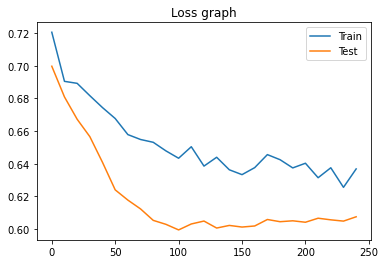

In [113]:
import matplotlib.pyplot as plt

x_tick = np.arange(0, len(train_loss_list) * 10, 10)
plt.title('Loss graph')
plt.plot(x_tick, train_loss_list, label='Train')
plt.plot(x_tick, test_loss_list, label='Test')
plt.legend()

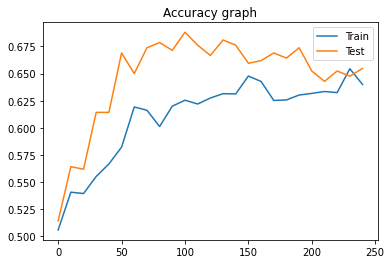

In [114]:
x_tick = np.arange(0, len(train_acc_list) * 10, 10)
plt.title('Accuracy graph')
plt.plot(x_tick, train_acc_list, label='Train')
plt.plot(x_tick, test_acc_list, label='Test')
plt.legend()

In [115]:
model_save='/Users/eunice/Desktop/Desktop/P300_biosemi_55/Model/Bio/ZERO_Bio.pt'
model_save_weights='/Users/eunice/Desktop/Desktop/P300_biosemi_55/Model/Bio/Weight/ZERO_Weight_Bio.pt'

torch.save(model, model_save)
torch.save(model.state_dict(), model_save_weights)
model.eval()

CNN(
  (bn1): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv): Sequential(
    (0): Conv1d(7, 3, kernel_size=(3,), stride=(1,), padding=(True,))
    (1): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=135, out_features=2, bias=True)
    (1): Softmax(dim=None)
  )
)

In [116]:
import numpy as np
from scipy.signal import butter, lfilter, sosfiltfilt
import time
import os, glob
import hdf5storage
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import joblib
import shutil
from datetime import datetime
import socket
from scipy import signal
import matplotlib.pyplot as plt
from keras.models import load_model

Classifier_path = '/Users/eunice/Desktop/Desktop/P300_biosemi_55/Model/Bio/'
classifier_list = sorted(glob.glob(Classifier_path + '*.pt'), key=os.path.getmtime, reverse=True)
weight_list = sorted(glob.glob(Classifier_path + 'Weight/*.pt'), key=os.path.getmtime, reverse=True)
model = torch.load(classifier_list[0])
model.load_state_dict(torch.load(weight_list[0]))

# filtering bandwidth
low, high = 0.23, 30

resampleRate = 300    
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y

def Standardization(Epochs):
    for i in range(Epochs.shape[1]):
        Epochs[:,i,:] = np.subtract(Epochs[:,i,:], np.mean(Epochs[:,i,:]))
        Epochs[:,i,:] = Epochs[:,i,:] / np.std(Epochs[:,i,:])
    
    return Epochs    
def baseline_correction(Epochs):
    for i in range(Epochs.shape[1]):
        for j in range(Epochs.shape[0]):
            Epochs[j,i,:] = np.subtract(Epochs[j,i,:], np.mean(Epochs[j,i,:]))
    
    return Epochs       
def Epoching(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
            for i in range(nChannel):
                Epochs[j,i,:] = Epochs[j,i,:] - np.mean(Epochs[j,i,:])
                
        #Epochs = baseline_correction(Epochs)
        Epochs_Aver = np.mean(Epochs, axis=0)

        return Epochs_Aver
    
def Convert_to_FeatureVector(Epochs, buttonNum, featureNum):
    Features = np.zeros((buttonNum, featureNum))
    for i in range(buttonNum):
        Features[i, :] = np.reshape(Epochs[i, :, :], (1, featureNum))
    return Features

def resampling(Epochs, resampleRate, channelNum):
        resampled_epoch = np.zeros((channelNum, resampleRate))
        for j in range(channelNum):
            resampled_epoch[j,:] = signal.resample(Epochs[j,:], resampleRate)
            
        return resampled_epoch
    
def main():
    Total_Score=0.0
    for k in np.arange(1,21):
        root="/Users/eunice/Desktop/Desktop/실험데이터/S"
        if(k<10):
            filename = root + '0' + str(k)
        else:
            filename = root + str(k)
        #root_path = "D:\\VR300_20\\S03\\"

        mat_path = filename + '/Online/mat/'
        current_list = sorted(glob.glob(mat_path + '*.mat'), key=os.path.getmtime)
        score = 0
        wrong_ans = []
        
        target_val = nontarget_val = 0
        for mat_file in current_list:
            #print(mat_file)
            ans = mat_file[-5]
            
            mat = hdf5storage.loadmat(mat_file)
            channelNames = mat['channelNames']
            eegData = mat['eegData']
            samplingFreq = mat['samplingFreq']
            samplingFreq = samplingFreq[0,0]
            stims = mat['stims']
            channelNum = channelNames.shape
            channelNum = channelNum[1]
            eegData = np.transpose(eegData)
            buttonNum = 7
            
            #Bandpass Filter
            eegData = butter_bandpass_filter(eegData, low, high, samplingFreq, order=4)

            #Epoching
            epochSampleNum = int(np.floor(0.6 * samplingFreq))
            offset = int(np.floor(0.2 * samplingFreq))
            baseline = int(np.floor(0.8 * samplingFreq))
            
            ####### averaging whole epochs
            Epochs_Aver = np.zeros((buttonNum, channelNum, epochSampleNum))
            Epochs_final = np.zeros((buttonNum, channelNum, resampleRate))
            
            featureNum = channelNum*resampleRate
            
            for i in range(buttonNum):
                Epochs_Aver[i] = Epoching(eegData, stims, (i+1), samplingFreq, channelNum, epochSampleNum, offset, baseline)
                Epochs_final[i] = resampling(Epochs_Aver[i], resampleRate, channelNum)
            #answer=model(Epochs_final)
            
            #print(Epochs_Aver.shape)
            b=torch.Tensor(Epochs_Aver[:,:,:].reshape(7,7,180)).to(DEVICE)
            test_output=model(b)
            test_output[:, 1].max(dim=0)
            #print(test_output)
            predict= test_output[:, 1].max(dim=0)[1]+1
            
            if int(ans) == int(predict): 
                score = score + 1
            else:
                wrong_ans.append(mat_file[mat_file.rfind('\\')+1:mat_file.rfind('_')])
            #print('order: ', ans, 'predict: ', predict)
            
        #print('wrong answer', wrong_ans)
        print(k,'score:', score/(len(wrong_ans)+score))
        if (k==7 or k==13 ):
            continue
        else:
            Total_Score=Total_Score+score/(len(wrong_ans)+score)
    print(Total_Score/18.0)
if __name__ == "__main__":
    main()

1 score: 0.65
2 score: 0.4666666666666667
3 score: 0.4
4 score: 0.4666666666666667
5 score: 0.43333333333333335
6 score: 0.7666666666666667
7 score: 0.23333333333333334
8 score: 0.9
9 score: 0.5333333333333333
10 score: 0.5666666666666667
11 score: 0.5
12 score: 0.43333333333333335
13 score: 0.4
14 score: 0.4
15 score: 0.43333333333333335
16 score: 0.4
17 score: 0.8
18 score: 0.6666666666666666
19 score: 0.9333333333333333
20 score: 0.7333333333333333
0.5824074074074075


subject 1 is preprocessed
subject 2 is preprocessed
subject 3 is preprocessed
subject 4 is preprocessed
subject 5 is preprocessed
subject 7 is preprocessed
subject 8 is preprocessed
subject 9 is preprocessed
subject 10 is preprocessed
subject 11 is preprocessed
subject 12 is preprocessed
subject 13 is preprocessed
subject 14 is preprocessed
subject 15 is preprocessed
subject 16 is preprocessed
subject 17 is preprocessed
subject 18 is preprocessed
subject 19 is preprocessed
subject 20 is preprocessed
subject 21 is preprocessed
subject 22 is preprocessed
subject 23 is preprocessed
subject 24 is preprocessed
subject 26 is preprocessed
subject 27 is preprocessed
subject 28 is preprocessed
subject 29 is preprocessed
subject 30 is preprocessed
subject 31 is preprocessed
subject 32 is preprocessed
subject 33 is preprocessed
subject 34 is preprocessed
subject 35 is preprocessed
subject 36 is preprocessed
subject 37 is preprocessed
subject 39 is preprocessed
subject 40 is preprocessed
subject 4

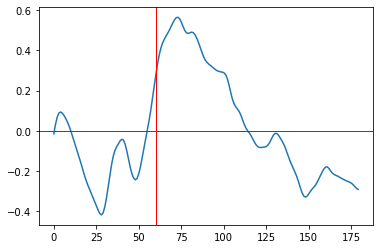

2


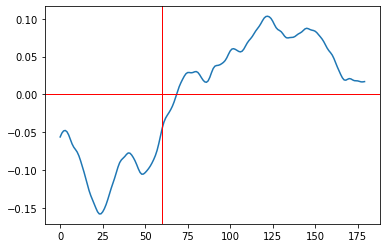

3


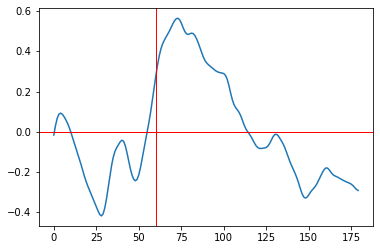

4


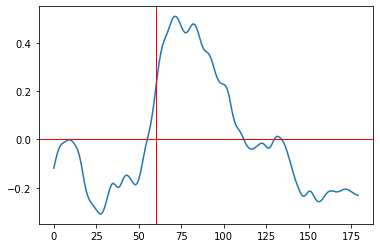

5


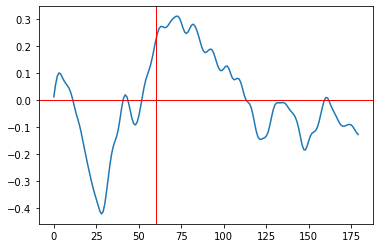

6


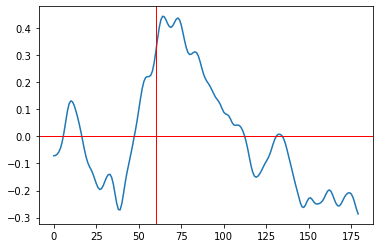

7


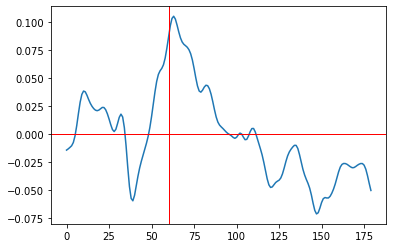

start:
32
finish:
212
start:
65
finish:
245
start:
14
finish:
194
start:
13
finish:
193
start:
17
finish:
197
start:
24
finish:
204
start:
24
finish:
204
/Users/eunice/Desktop/Desktop/실험데이터/S02/Training/mat/Training-[2020.11.14-13.14.51].mat
1


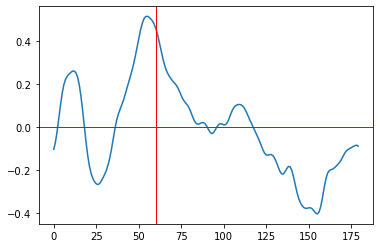

2


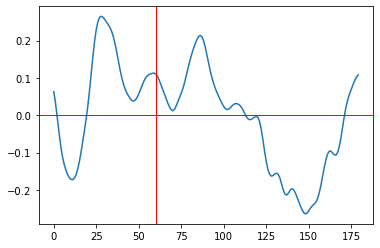

3


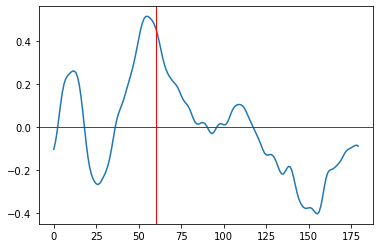

4


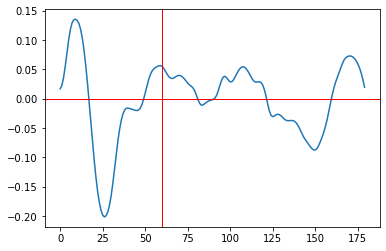

5


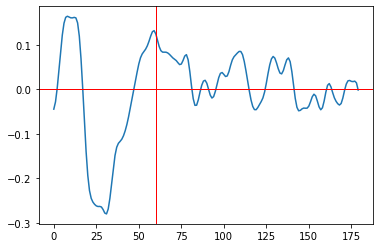

6


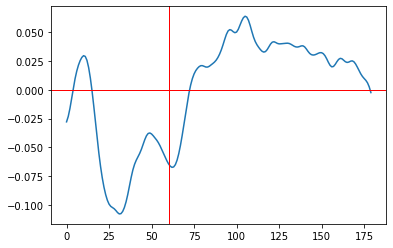

7


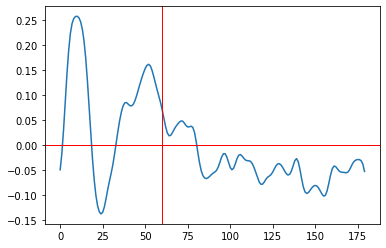

start:
52
finish:
232
start:
1
finish:
181
start:
31
finish:
211
start:
55
finish:
235
start:
55
finish:
235
start:
60
finish:
240
start:
92
finish:
272
/Users/eunice/Desktop/Desktop/실험데이터/S03/Training/mat/Training-[2020.11.12-19.21.39].mat
1


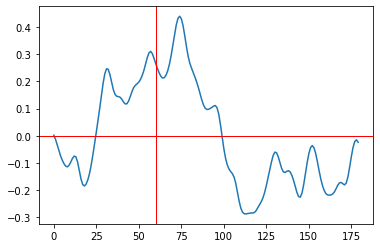

2


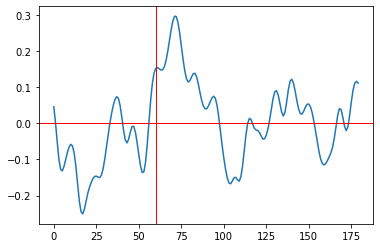

3


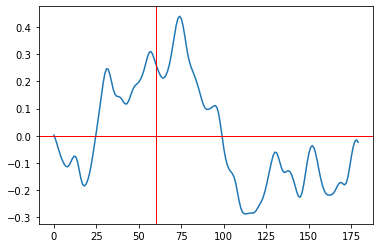

4


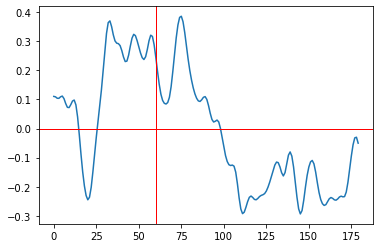

5


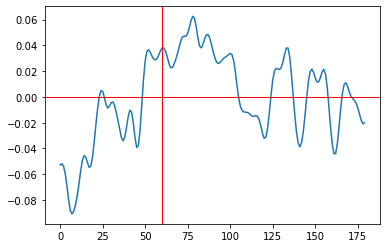

6


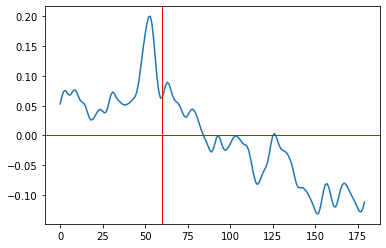

7


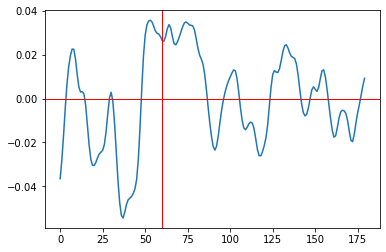

start:
45
finish:
225
start:
74
finish:
254
start:
45
finish:
225
start:
46
finish:
226
start:
81
finish:
261
start:
68
finish:
248
start:
24
finish:
204
/Users/eunice/Desktop/Desktop/실험데이터/S04/Training/mat/Training-[2020.11.14-14.12.23].mat
1


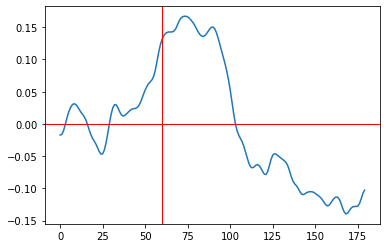

2


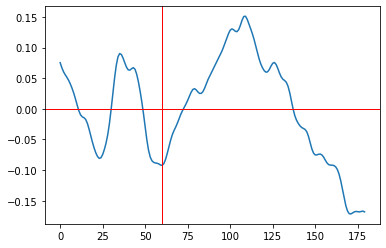

3


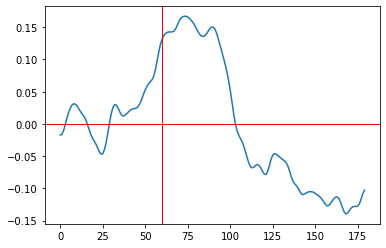

4


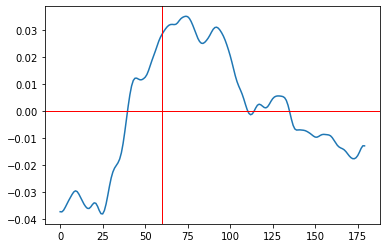

5


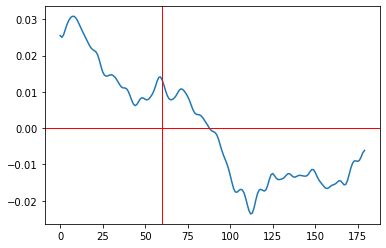

6


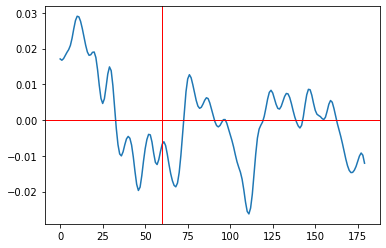

7


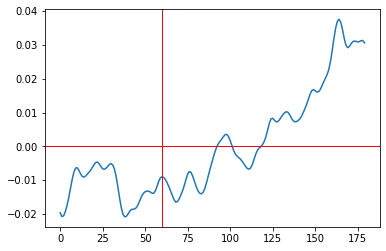

start:
39
finish:
219
start:
120
finish:
300
start:
18
finish:
198
start:
21
finish:
201
start:
74
finish:
254
start:
117
finish:
297
start:
36
finish:
216
/Users/eunice/Desktop/Desktop/실험데이터/S05/Training/mat/Training-[2020.11.14-15.20.38].mat
1


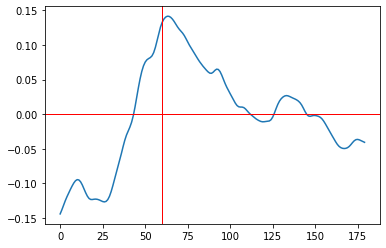

2


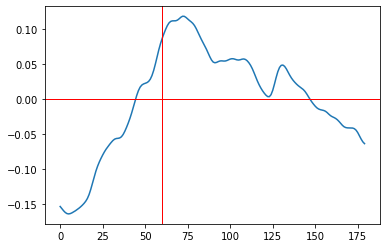

3


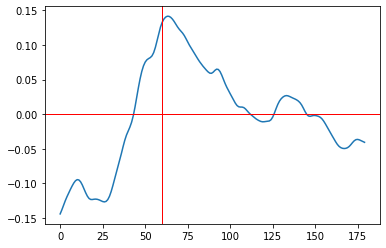

4


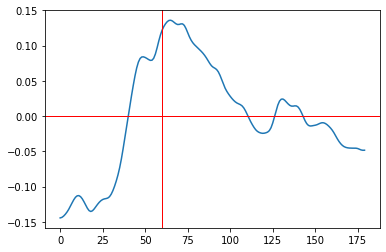

5


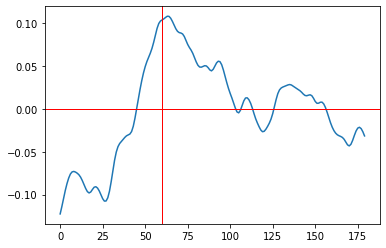

6


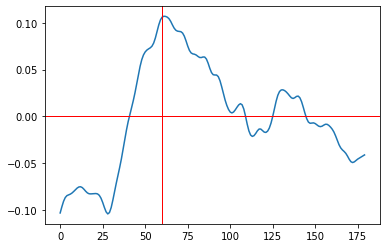

7


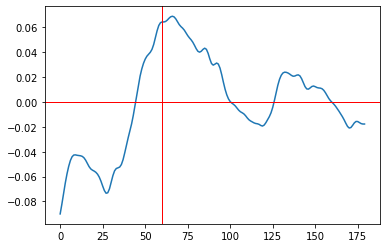

start:
120
finish:
300
start:
78
finish:
258
start:
117
finish:
297
start:
24
finish:
204
start:
23
finish:
203
start:
120
finish:
300
start:
76
finish:
256
/Users/eunice/Desktop/Desktop/실험데이터/S06/Training/mat/Training-[2020.11.14-16.13.30].mat
1


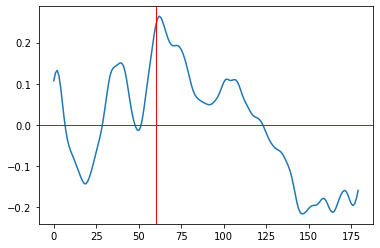

2


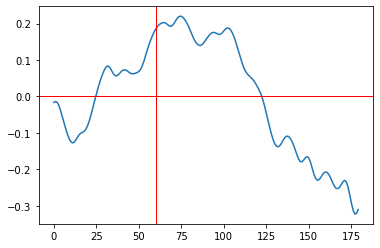

3


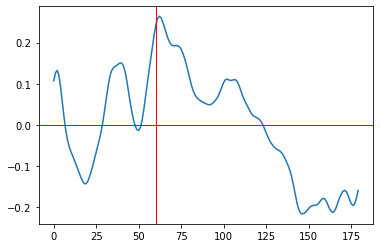

4


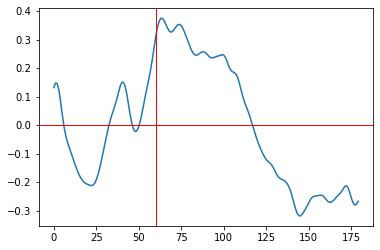

5


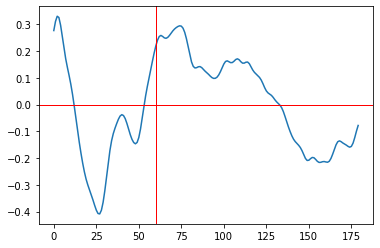

6


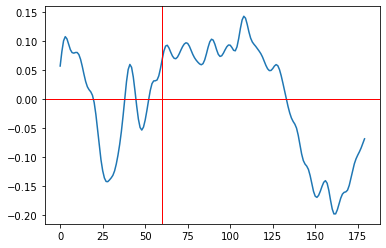

7


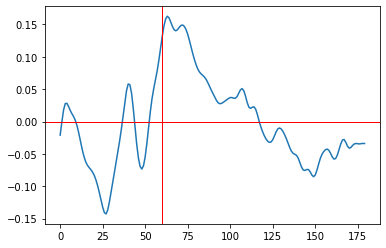

start:
40
finish:
220
start:
9
finish:
189
start:
25
finish:
205
start:
34
finish:
214
start:
18
finish:
198
start:
18
finish:
198
start:
28
finish:
208
/Users/eunice/Desktop/Desktop/실험데이터/S07/Training/mat/Training-[2020.11.14-17.09.12].mat
1


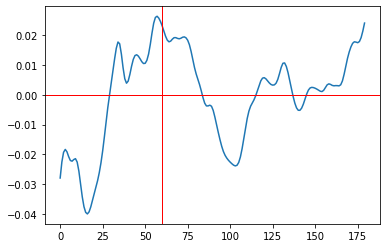

2


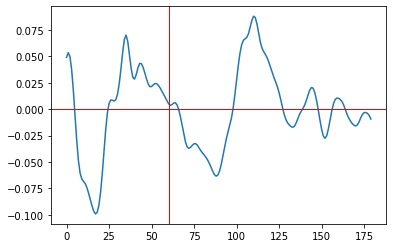

3


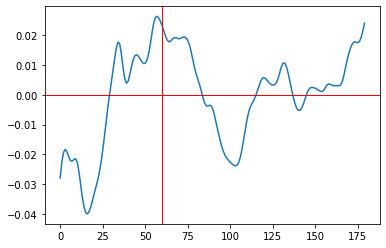

4


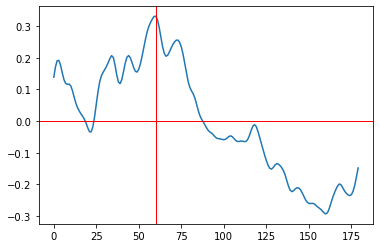

5


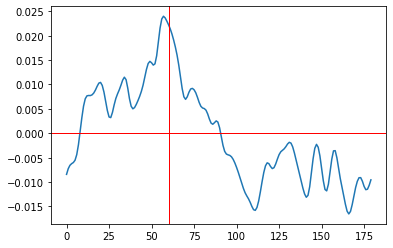

6


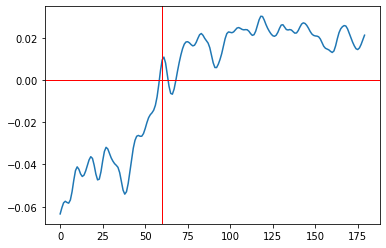

7


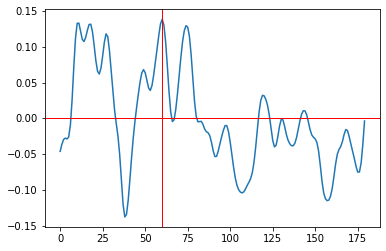

start:
120
finish:
300
start:
13
finish:
193
start:
120
finish:
300
start:
77
finish:
257
start:
28
finish:
208
start:
90
finish:
270
start:
27
finish:
207
/Users/eunice/Desktop/Desktop/실험데이터/S08/Training/mat/Training-[2020.11.14-18.12.20].mat
1


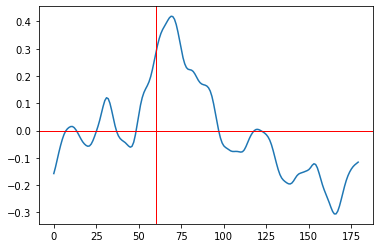

2


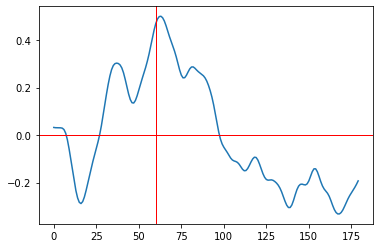

3


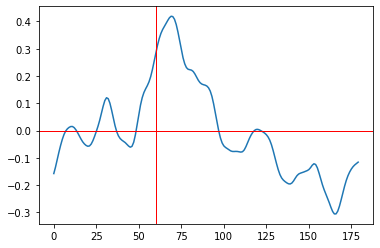

4


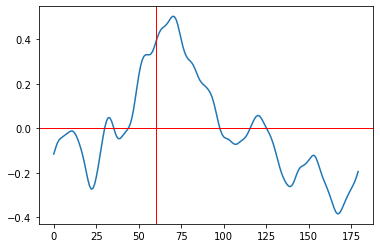

5


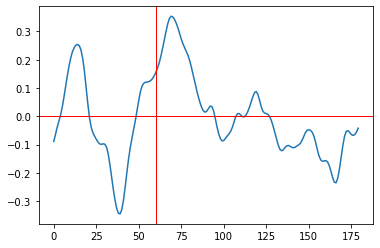

6


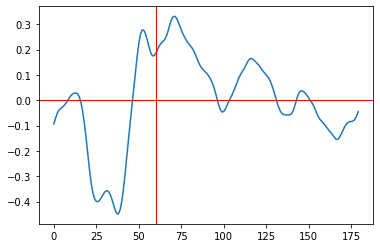

7


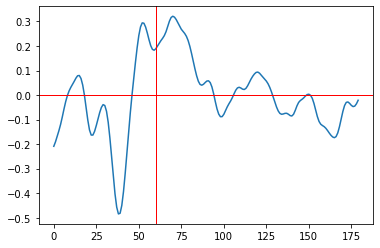

start:
42
finish:
222
start:
35
finish:
215
start:
19
finish:
199
start:
24
finish:
204
start:
18
finish:
198
start:
21
finish:
201
start:
26
finish:
206
/Users/eunice/Desktop/Desktop/실험데이터/S09/Training/mat/Training-[2020.11.15-13.15.59].mat
1


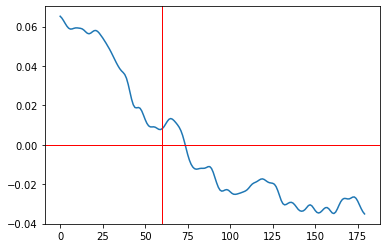

2


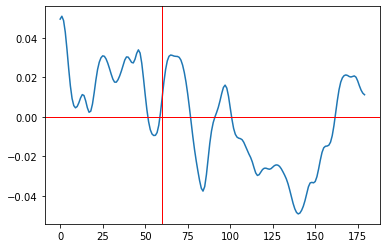

3


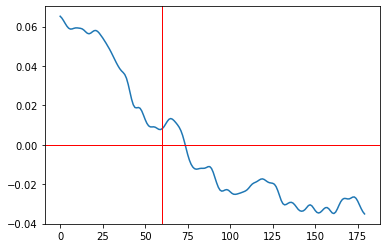

4


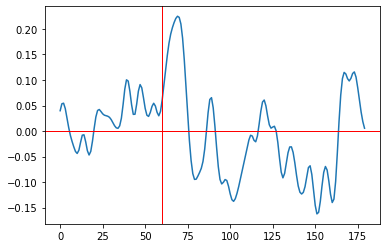

5


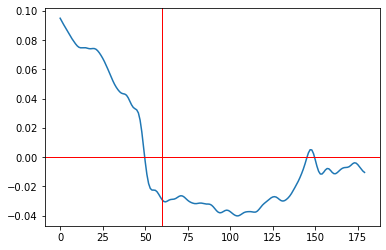

6


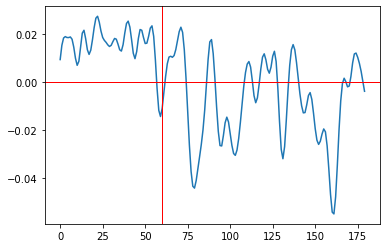

7


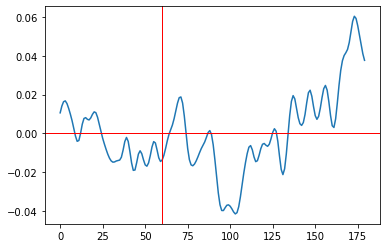

start:
97
finish:
277
start:
58
finish:
238
start:
74
finish:
254
start:
0
finish:
180
start:
73
finish:
253
start:
99
finish:
279
start:
0
finish:
180
/Users/eunice/Desktop/Desktop/실험데이터/S10/Training/mat/Training-[2020.11.15-14.15.44].mat
1


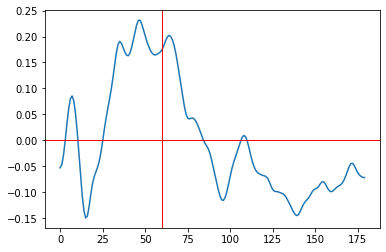

2


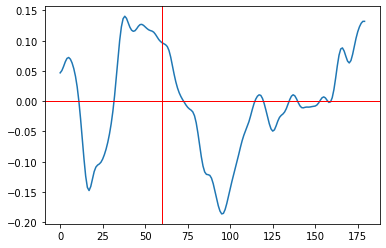

3


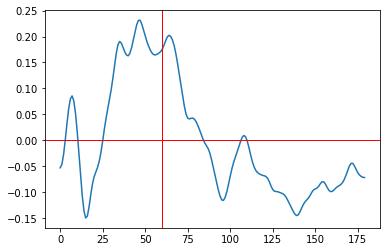

4


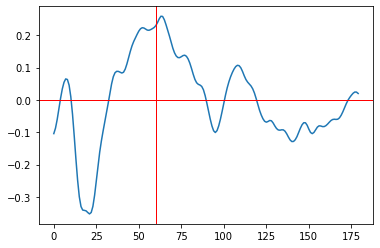

5


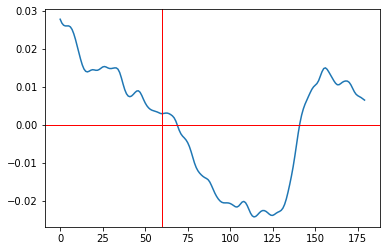

6


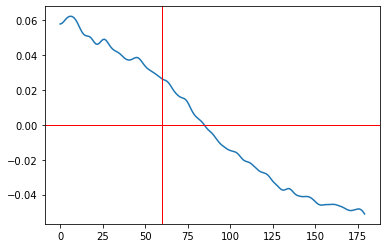

7


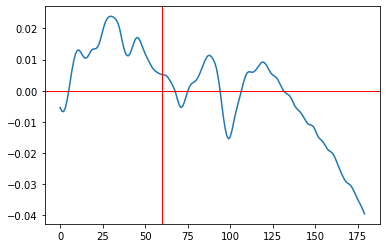

start:
63
finish:
243
start:
42
finish:
222
start:
41
finish:
221
start:
34
finish:
214
start:
79
finish:
259
start:
75
finish:
255
start:
66
finish:
246
/Users/eunice/Desktop/Desktop/실험데이터/S11/Training/mat/Training-[2020.11.15-15.12.43].mat
1


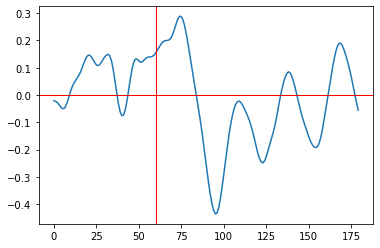

2


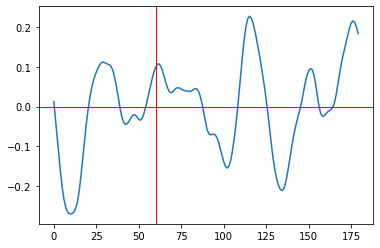

3


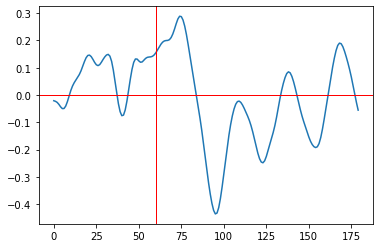

4


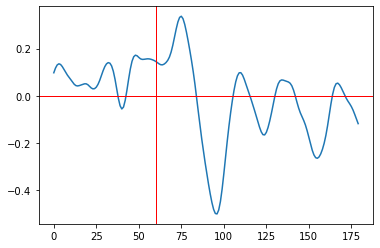

5


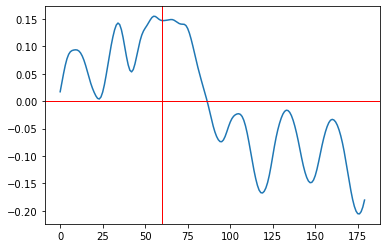

6


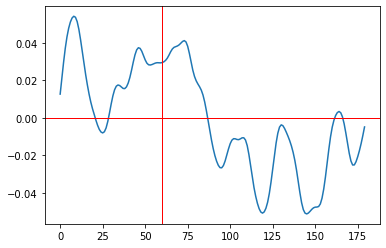

7


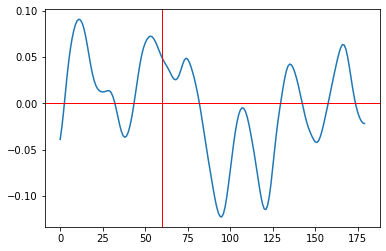

start:
55
finish:
235
start:
112
finish:
292
start:
68
finish:
248
start:
75
finish:
255
start:
27
finish:
207
start:
77
finish:
257
start:
3
finish:
183
/Users/eunice/Desktop/Desktop/실험데이터/S12/Training/mat/Training-[2020.11.15-16.13.38].mat
1


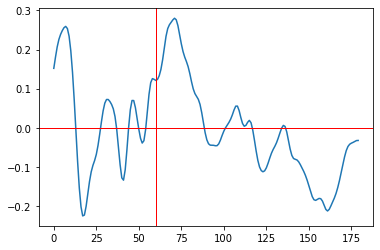

2


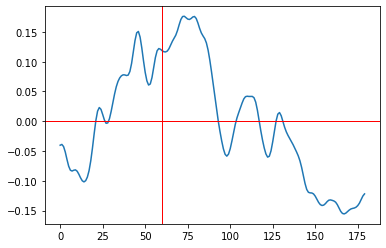

3


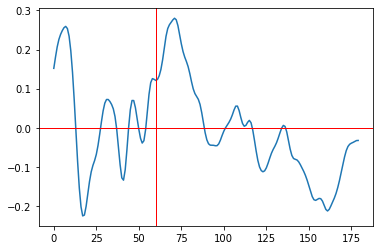

4


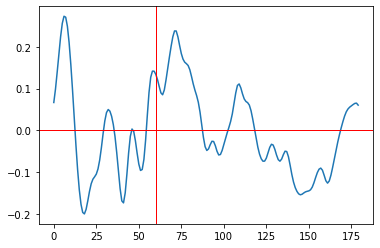

5


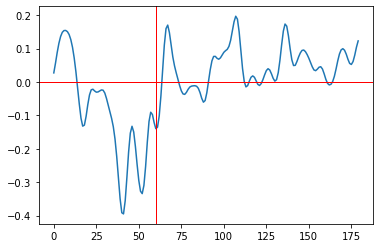

6


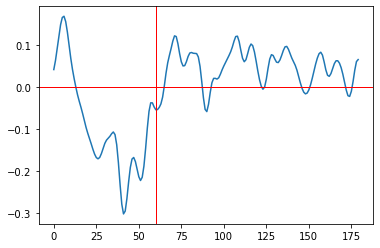

7


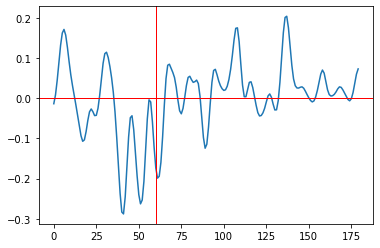

start:
51
finish:
231
start:
21
finish:
201
start:
19
finish:
199
start:
22
finish:
202
start:
42
finish:
222
start:
60
finish:
240
start:
51
finish:
231
/Users/eunice/Desktop/Desktop/실험데이터/S13/Training/mat/Training-[2020.11.15-17.14.46].mat
1


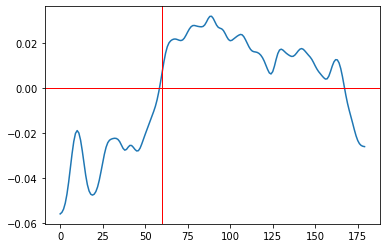

2


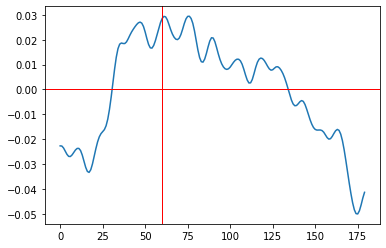

3


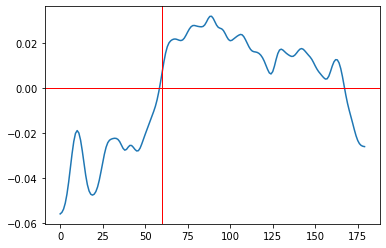

4


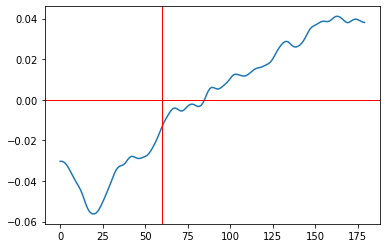

5


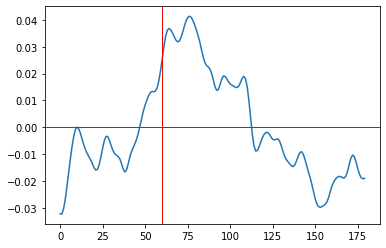

6


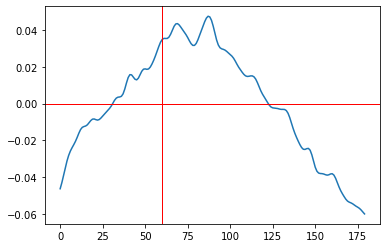

7


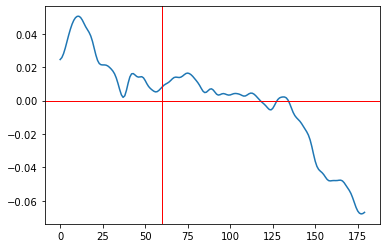

start:
105
finish:
285
start:
36
finish:
216
start:
98
finish:
278
start:
68
finish:
248
start:
16
finish:
196
start:
26
finish:
206
start:
85
finish:
265
/Users/eunice/Desktop/Desktop/실험데이터/S14/Training/mat/Training-[2020.11.15-18.08.30].mat
1


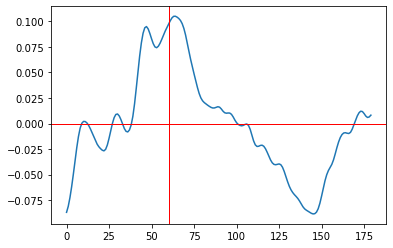

2


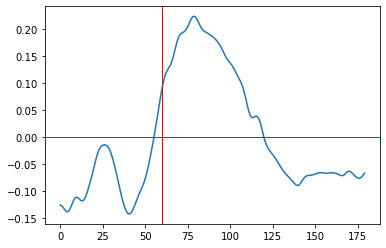

3


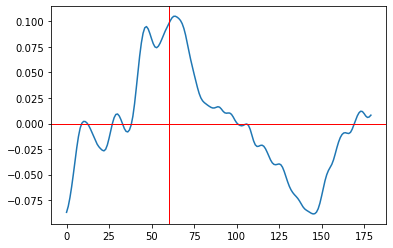

4


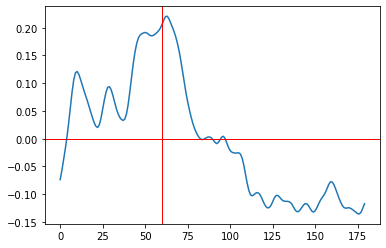

5


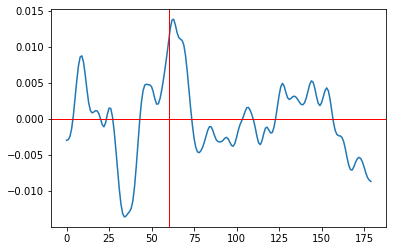

6


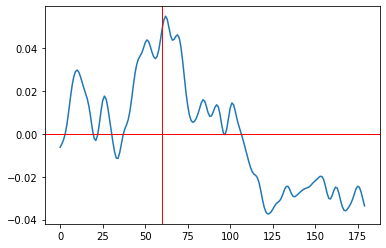

7


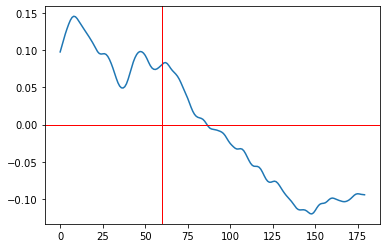

start:
55
finish:
235
start:
9
finish:
189
start:
33
finish:
213
start:
42
finish:
222
start:
24
finish:
204
start:
34
finish:
214
start:
70
finish:
250
/Users/eunice/Desktop/Desktop/실험데이터/S15/Training/mat/Training-[2020.11.16-19.17.17].mat
1


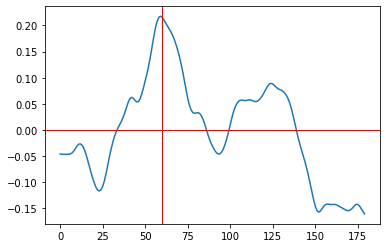

2


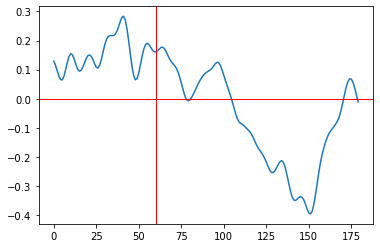

3


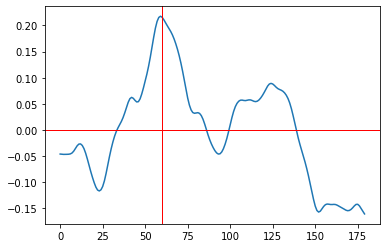

4


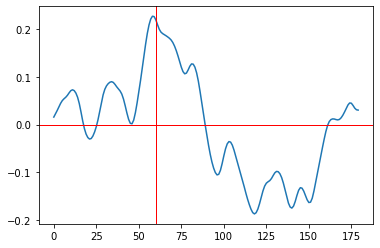

5


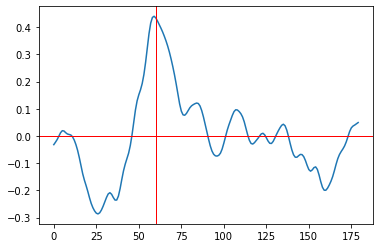

6


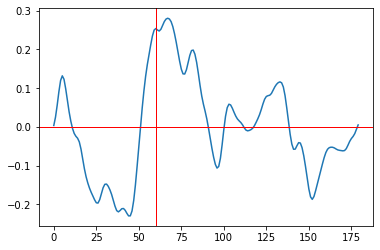

7


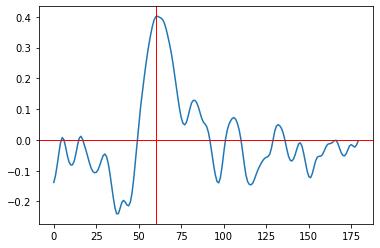

start:
41
finish:
221
start:
39
finish:
219
start:
27
finish:
207
start:
73
finish:
253
start:
24
finish:
204
start:
21
finish:
201
start:
22
finish:
202
/Users/eunice/Desktop/Desktop/실험데이터/S16/Training/mat/Training-[2020.11.16-20.17.33].mat
1


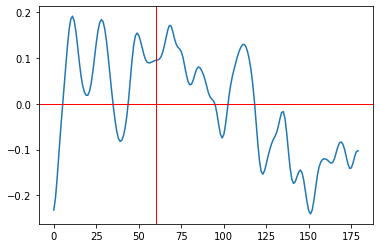

2


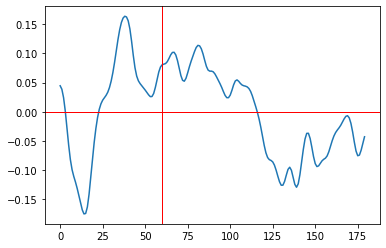

3


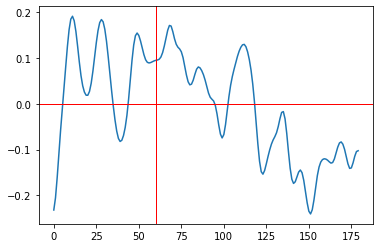

4


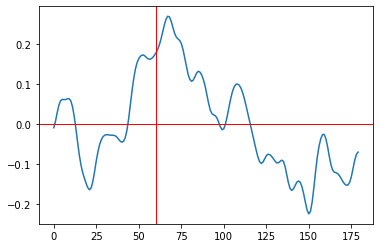

5


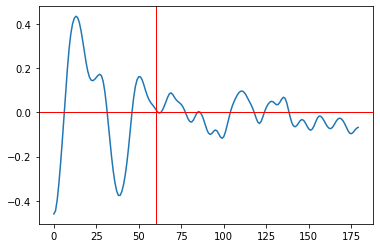

6


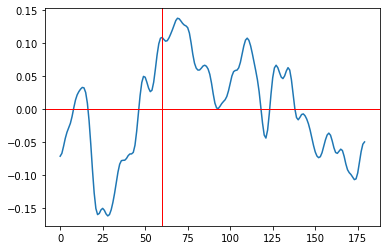

7


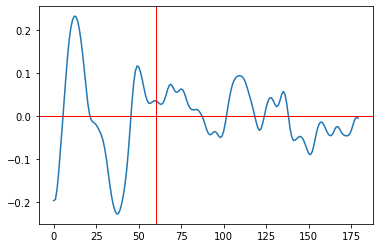

start:
51
finish:
231
start:
45
finish:
225
start:
25
finish:
205
start:
26
finish:
206
start:
69
finish:
249
start:
21
finish:
201
start:
120
finish:
300
/Users/eunice/Desktop/Desktop/실험데이터/S17/Training/mat/Training-[2020.11.16-21.17.08].mat
1


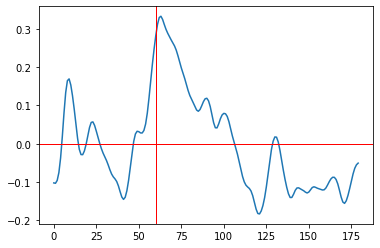

2


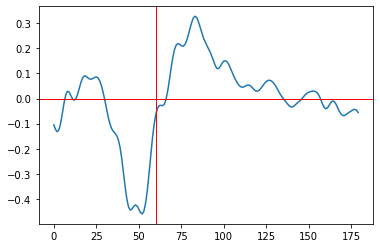

3


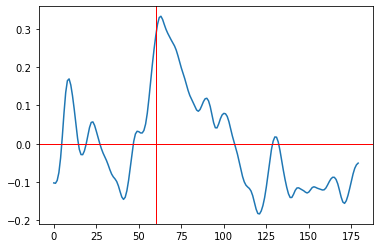

4


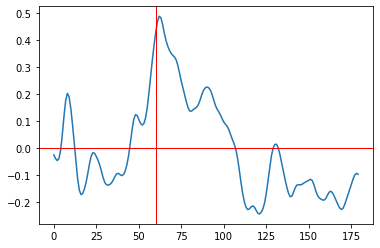

5


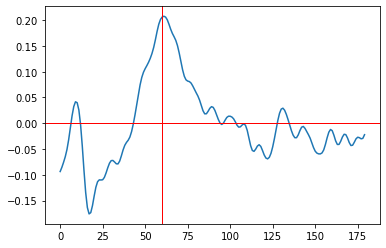

6


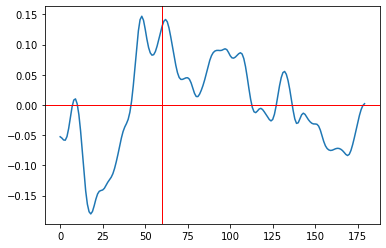

7


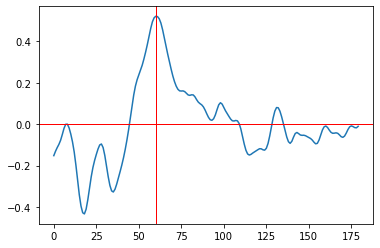

start:
39
finish:
219
start:
45
finish:
225
start:
20
finish:
200
start:
20
finish:
200
start:
26
finish:
206
start:
30
finish:
210
start:
26
finish:
206
/Users/eunice/Desktop/Desktop/실험데이터/S18/Training/mat/Training-[2020.11.17-19.30.07].mat
1


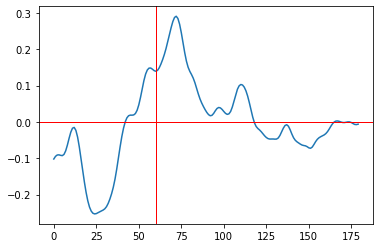

2


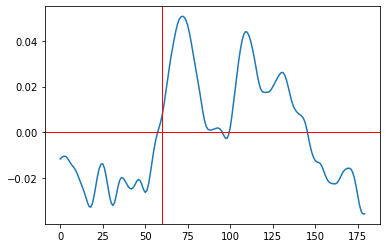

3


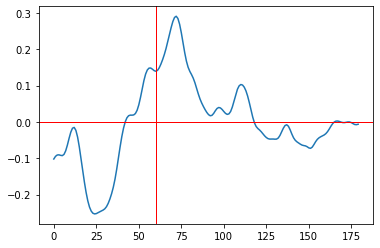

4


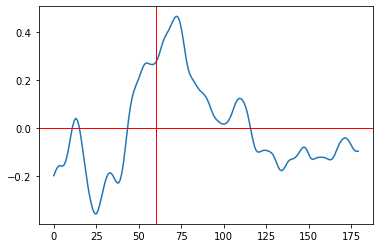

5


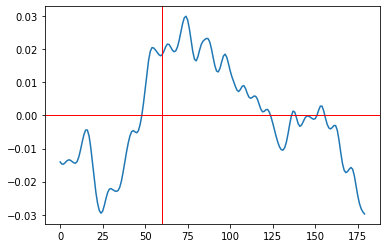

6


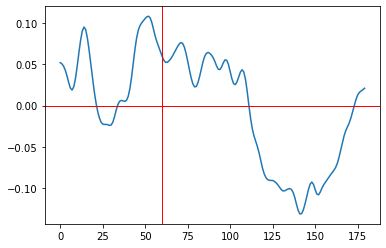

7


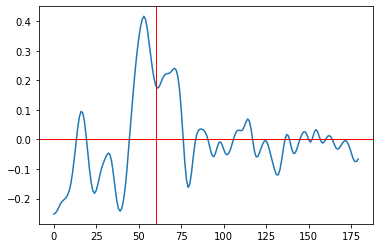

start:
120
finish:
300
start:
68
finish:
248
start:
114
finish:
294
start:
26
finish:
206
start:
18
finish:
198
start:
35
finish:
215
start:
32
finish:
212
/Users/eunice/Desktop/Desktop/실험데이터/S19/Training/mat/Training-[2020.11.17-20.15.41].mat
1


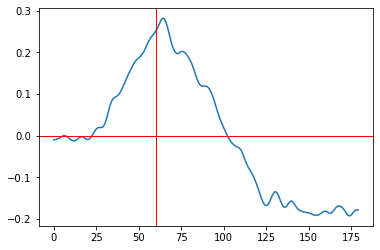

2


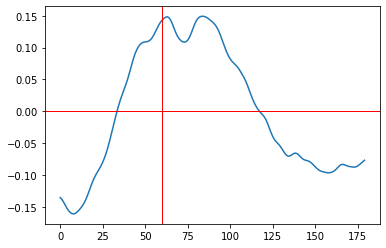

3


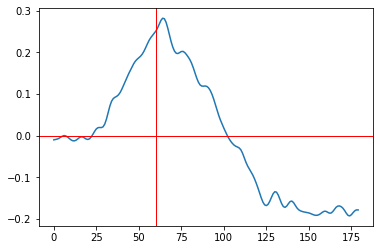

4


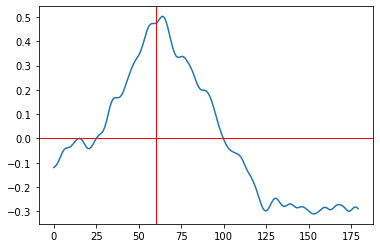

5


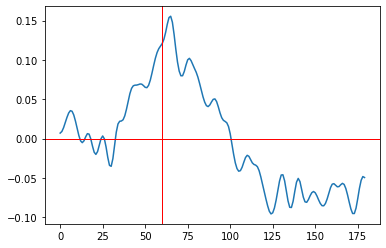

6


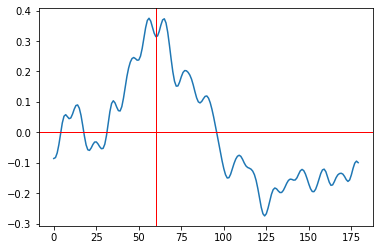

7


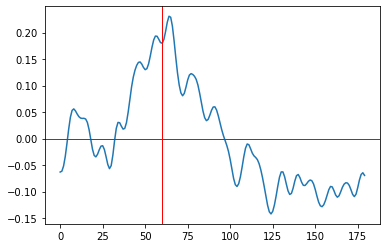

start:
47
finish:
227
0.28227362976421044
0.11624214694908319


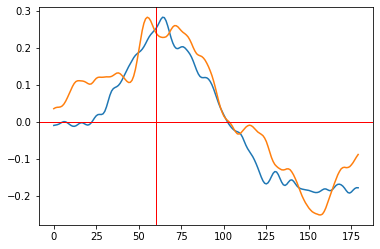

here
start:
12
finish:
192
0.14912304979145688
0.24366771120638958


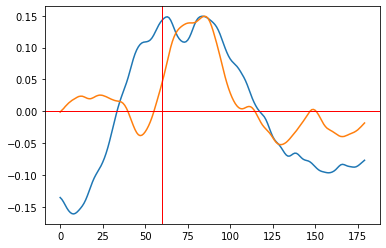

here
start:
32
finish:
212
0.28227359362075477
0.34203717679990353


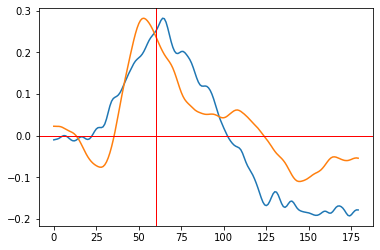

here
start:
38
finish:
218
0.5032719875489783
0.11080449819656192


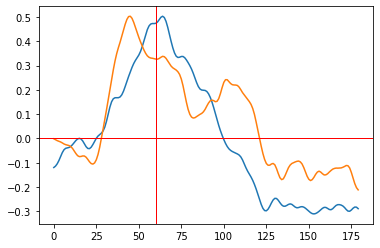

here
start:
26
finish:
206
inverse
0.15547440336214174
0.34086332629346605


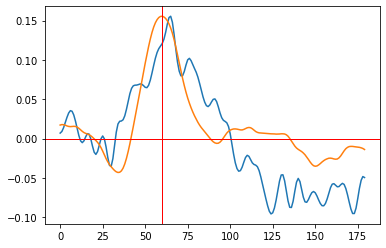

here
start:
38
finish:
218
inverse
0.3749918112914492
0.20063245670399843


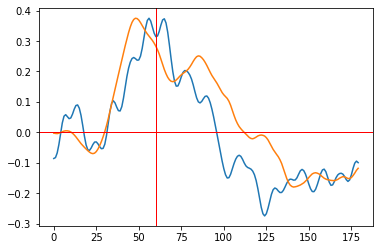

here
start:
35
finish:
215
inverse
0.2308476491295859
0.42624276277906964


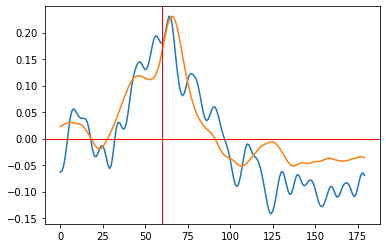

here


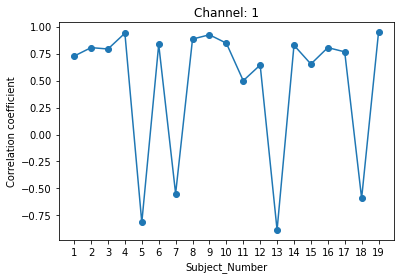

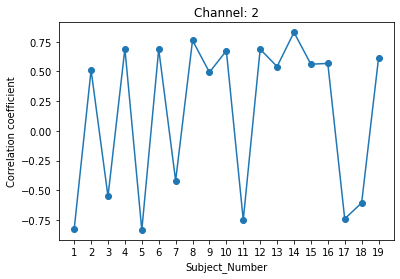

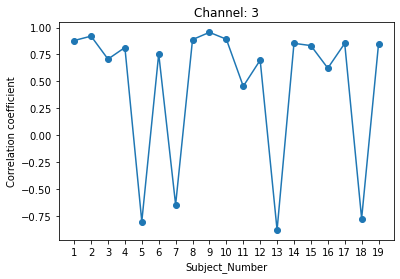

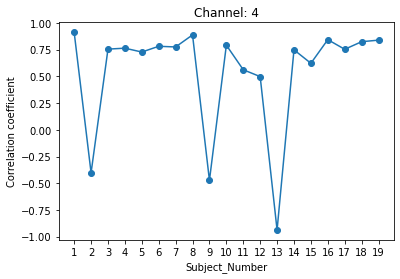

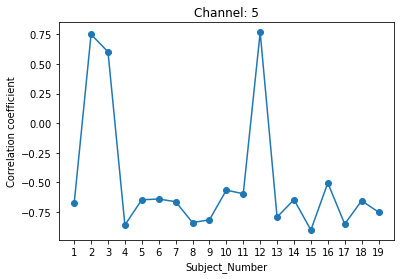

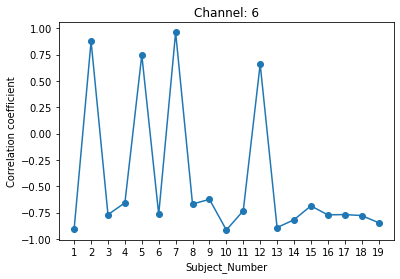

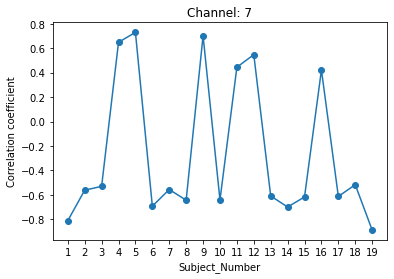

(11340, 7, 180)
(11340, 7, 180)
1


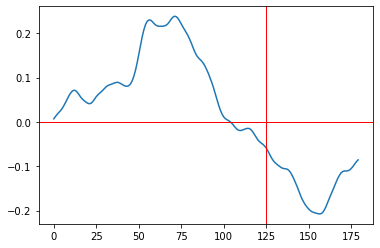

2


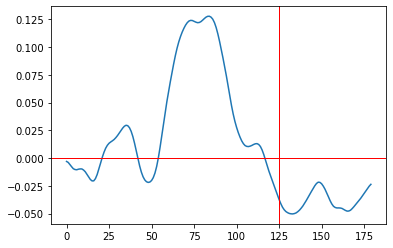

3


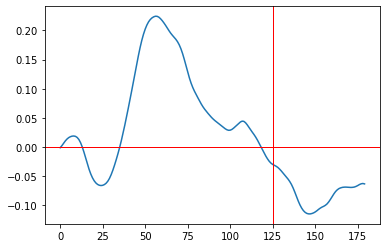

4


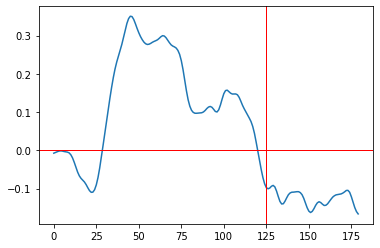

5


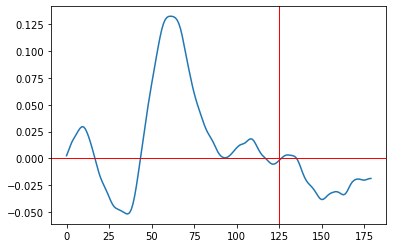

6


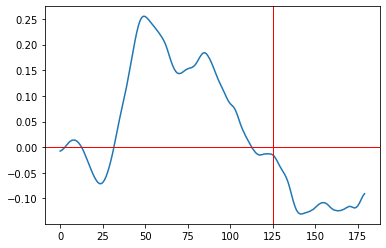

7


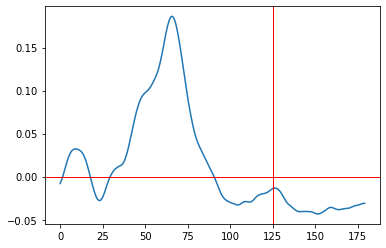

In [105]:
# DataProcessing and model generation process
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import hdf5storage
import numpy as np
from scipy.signal import butter, lfilter
import os,glob
from scipy import signal
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline

def Re_referencing(eegData, channelNum, sampleNum):
        after_car = np.zeros((channelNum,sampleNum))
        for i in np.arange(channelNum):
            after_car[i,:] = eegData[i,:] - np.mean(eegData,axis=0)
        return after_car

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y
def Make_Average_Component(EpochsT, NumT, EpochsN, NumN, channelNum, epochSampleNum, componentNum):
    NumT_Aver = NumT-componentNum
    NumN_Aver = NumN-componentNum
    
    EpochsT_Aver = np.zeros((NumT_Aver, channelNum, epochSampleNum))
    EpochsN_Aver = np.zeros((NumN_Aver, channelNum, epochSampleNum))
    for i in range(NumT_Aver):
        EpochsT_Aver[i, :, :] = np.mean(EpochsT[i:i+componentNum, :, :], axis=0)
    for j in range(NumN_Aver):
        EpochsN_Aver[j, :, :] = np.mean(EpochsN[j:j+componentNum, :, :], axis=0)
        
    return [EpochsT_Aver, NumT_Aver, EpochsN_Aver, NumN_Aver]


def Epoching(eegData, stims, samplingFreq, channelNum, epochSampleNum, offset, baseline):
        Time_after = np.add(stims,offset).astype(int)
        Time_base = np.add(stims,baseline).astype(int)
        Num = stims.shape[1]
        Epochs = np.zeros((Num, channelNum, epochSampleNum))
        for j in range(Num):
            Epochs[j, :, :] = eegData[:,Time_after[0][j]:Time_after[0][j] + epochSampleNum]
            
        return [Epochs,Num]


def resampling(Epochs, EpochNum, resampleRate, channelNum):
        resampled_epoch = np.zeros((EpochNum, channelNum, resampleRate))
        for i in range(EpochNum):
            for j in range(channelNum):
                resampled_epoch[i,j,:] = signal.resample(Epochs[i,j,:], resampleRate)
        return resampled_epoch


    

def Epoching_d(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
        return [Epochs, Num[0]]

def Convert_to_featureVector(EpochsT, NumT, EpochsN, NumN, featureNum):
        FeaturesT = np.zeros((NumT, featureNum))
        for i in range(NumT):
            FeaturesT[i,:] = np.reshape(EpochsT[i,:,:],(1,featureNum))
        FeaturesN = np.zeros((NumN, featureNum))
        for j in range(NumN):
            FeaturesN[j,:] = np.reshape(EpochsN[j,:,:],(1,featureNum))
        return [FeaturesT,FeaturesN]


def Balancing_DataSet(Epochs, size):
        Epochs_New = np.zeros((size, Epochs.shape[1], Epochs.shape[2]))
    
        index = np.random.choice(Epochs.shape[0], size = size, replace = False)
    
        Epochs_New = Epochs[index, :, :]
    
        return Epochs_New
    
def Standardization(Epochs):
        for i in range(Epochs.shape[1]):
            Epochs[:,i,:] = np.subtract(Epochs[:,i,:], np.mean(Epochs[:,i,:]))
            Epochs[:,i,:] = Epochs[:,i,:] / np.std(Epochs[:,i,:])
    
        return Epochs
    
def baseline_correction(Epochs):
    for i in range(Epochs.shape[1]):
        for j in range(Epochs.shape[0]):
            Epochs[j,i,:] = np.subtract(Epochs[j,i,:], np.mean(Epochs[j,i,:]))
    
    return Epochs
def Make_Average_Component_d(EpochsT, NumT, EpochsN, NumN, channelNum, epochSampleNum, componentNum):
        EpochsT = Standardization(EpochsT)
        EpochsN = Standardization(EpochsN)
        NumT_Aver = NumT-componentNum
        NumN_Aver = NumN-componentNum
    
        EpochsT_Aver = np.zeros((NumT_Aver, channelNum, epochSampleNum))
        EpochsN_Aver = np.zeros((NumN_Aver, channelNum, epochSampleNum))
        for i in range(NumT_Aver):
            EpochsT_Aver[i, :, :] = np.mean(EpochsT[i:i+componentNum, :, :], axis=0)
        for j in range(NumN_Aver):
            EpochsN_Aver[j, :, :] = np.mean(EpochsN[j:j+componentNum, :, :], axis=0)
        
        return [EpochsT_Aver, NumT_Aver, EpochsN_Aver, NumN_Aver]

def plotGraph_v(filename):


        mat = hdf5storage.loadmat(filename)
        channelNames = mat['channelNames']
        eegData = mat['eegData']
        samplingFreq = mat['samplingFreq']
        samplingFreq = samplingFreq[0,0]
        stims = mat['stims']
        channelNum = channelNames.shape
        channelNum = channelNum[1]
        eegData = np.transpose(eegData)
        
        ##Preprocessing process
        #eegData = Re_referencing(eegData, channelNum, eegData.shape[1])
        
        #Bandpass Filter
        eegData = butter_bandpass_filter(eegData, 0.23, 30, samplingFreq, order=4)
    
        #Epoching
        epochSampleNum = int(np.floor(0.6 * samplingFreq))
        offset = int(np.floor(0.2 * samplingFreq)) 
        baseline = int(np.floor(0.8 * samplingFreq)) 
        [EpochsT, NumT] = Epoching_d(eegData, stims, 1, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        [EpochsN, NumN] = Epoching_d(eegData, stims, 0, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        
        EpochsN_New = Balancing_DataSet(EpochsN, NumT)
        
        #Convert to feature vector
        #[EpochsT_Aver, NumT_Aver, EpochsN_Aver, NumN_Aver] = Make_Average_Component(EpochsT, NumT, EpochsN_New, NumT, channelNum, epochSampleNum, 20)
        EpochsT = Standardization(EpochsT)
        EpochsN = Standardization(EpochsN_New)
        Target_All=np.mean(EpochsT,axis=0)
        '''for k in np.arange(0,7):
            a=k+1
            print(a)
            plt.plot(Target_All[k,:])
            plt.axvline(x=60, color='r', linewidth=1)
            plt.axhline(y=0, color='r', linewidth=1)
            plt.show() 
        '''
        return [EpochsT[:,:,:], EpochsN[:,:,:]]    
def plotGraph_b(filename):
        channelNum = 7
        epochSampleNum = 512
        epochNum = 150
        resampleRate = 300
        target = np.zeros((epochNum,1,resampleRate))
        nontarget = np.zeros((epochNum,1,resampleRate))


        mat = hdf5storage.loadmat(filename)
        eegData = mat['eegData']
        samplingFreq = mat['samplingFreq'][0,0]
        stimsN = mat['stimsN']
        stimsT = mat['stimsT']
        sampleNum = eegData.shape[1]
        channelIndex = [18, 30, 12, 11, 19, 10, 15]
            
            # vr300 7 channel
            # [P4, Fz, Pz, P3, PO8, PO7, Oz]
            # [19, 31, 13, 12, 20, 11, 16]
            
        eegData = eegData[channelIndex]
            
            ## Preprocessing process
        eegData = Re_referencing(eegData, channelNum, eegData.shape[1])
            
            #Bandpass Filter
        eegData = butter_bandpass_filter(eegData, 0.23, 30, samplingFreq, 4)
        
#             #Epoching
        epochSampleNum = int(np.floor(1 * samplingFreq))
        offset = int(np.floor(0 * samplingFreq))
        baseline = int(np.floor(1 * samplingFreq))
        [EpochsT, NumT] = Epoching(eegData, stimsT, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        [EpochsN, NumN] = Epoching(eegData, stimsN, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        
        NumN = NumT
        EpochsN = Balancing_DataSet(EpochsN, NumN)
        
        EpochsT = Standardization(EpochsT)
        EpochsN = Standardization(EpochsN)
        #[EpochsT_Aver, NumT_Aver, EpochsN_Aver, NumN_Aver] = Make_Average_Component(EpochsT, NumT, EpochsN, NumN, channelNum, epochSampleNum, 0)
        EpochsT_Aver = resampling(EpochsT, NumT, resampleRate, channelNum) 
        EpochsN_Aver = resampling(EpochsN, NumN, resampleRate, channelNum)

        return [EpochsT_Aver, EpochsN_Aver]
def main():
    filename = ''
    channelNum = 7 # (n_components)
    epochSampleNum = 300
    epochNum = 150
    epochNum_N = 150 #원래 750
    subject_num = []
    root = '/Users/eunice/Desktop/Desktop/P300_biosemi_55/S'
    T_all = np.zeros((epochNum*(49 - len(subject_num)),channelNum,epochSampleNum))
    N_all = np.zeros((epochNum_N*(49 - len(subject_num)),channelNum,epochSampleNum))
    
    T_path = '/Users/eunice/Desktop/Desktop/P300_biosemi_55/New/T_all_I.out'
    N_path = '/Users/eunice/Desktop/Desktop/P300_biosemi_55/New/N_all_I.out'
    count = 0

    if not os.path.exists(T_path):
        for i in np.arange(1,56):
            count = count + 1
            if i in subject_num:
                count = count - 1
                continue
            if(i==25 or i==44 or i==53 or i==6 or i==38 or i==52): 
                count = count-1
                continue
            if(i<10):
                filename = root + '0' + str(i)
            else:
                filename = root + str(i)
            [T_all[epochNum*(count-1):epochNum*count,:,:],N_all[epochNum_N*(count-1):epochNum_N*count,:,:]] = plotGraph_b(filename)
            print("subject {0} is preprocessed".format(str(i)))
    
    
        T_all = np.reshape(T_all, (epochNum*(49 - len(subject_num)),channelNum*epochSampleNum))
        N_all = np.reshape(N_all, (epochNum_N*(49 - len(subject_num)),channelNum*epochSampleNum))
        
        #np.savetxt(T_path, T_all)
        #np.savetxt(N_path, N_all)
    else:
        T_all = np.loadtxt(T_path)
        N_all = np.loadtxt(N_path)
       
    T_all = np.reshape(T_all, (epochNum*(49 - len(subject_num)),channelNum,epochSampleNum))
    N_all = np.reshape(N_all, (epochNum_N*(49 - len(subject_num)),channelNum,epochSampleNum))            

    target_data_b = T_all
    non_target_data_b = N_all

    print("T_all shape: ", target_data_b.shape)
    print("N_all shape: ", non_target_data_b.shape)
    hz=180
    
    co = np.zeros((19,7))
    root = '/Users/eunice/Desktop/Desktop/실험데이터/S'
    count = 0
        
    for a in np.arange(1,20):
        if(a<10):
            count = count + 1
            root_VR = root + '0' + str(a)+'/Training/mat/'
            current_list = sorted(glob.glob(root_VR + '*.mat'), key=os.path.getmtime, reverse=True)
            root_VR = current_list[0]
        else:
            count = count + 1
            root_VR = root + str(a)+'/Training/mat/'
            current_list = sorted(glob.glob(root_VR + '*.mat'), key=os.path.getmtime, reverse=True)
            root_VR = current_list[0]
        print(root_VR)    
        T_all_V= np.zeros((210,7,hz))
        N_all_V= np.zeros((210,7,hz))
        [T_all_V[:,:,:],N_all_V[:,:,:]]=plotGraph_v(root_VR)
    
        Target_All=np.mean(T_all_V,axis=0)
        for k in np.arange(0,7):
            l=k+1
            print(l)
            plt.plot(Target_All[k,:])
            plt.axvline(x=60, color='r', linewidth=1)
            plt.axhline(y=0, color='r', linewidth=1)
            plt.show()    
    
        biosemi = np.mean(target_data_b, axis=0)
        mat = np.zeros((2, hz))
        for j in np.arange(0,7):
            mat[0] = Target_All[j,:]
            coef = np.zeros(300 - hz +1)
            for b in np.arange(0,300 - hz +1):
                mat[1] = biosemi[j,0*hz+1*b:1*hz+1*(b)]
                corrcoef = np.corrcoef(mat)
                coef[b] = corrcoef[0,1]
            index = np.argmax(np.abs(coef))
            co[a-1,j] = coef[index] 
        
        #biosemi 맞춰주기
            start = 0*hz+1*index
            finish = 1*hz+1*(index)
            print('start:')
            print(start)
            print('finish:')
            print(finish)
        
            if(a==19):
                T_all[:,j,0:hz] = T_all[:,j,start:finish]
                N_all[:,j,0:hz] = N_all[:,j,start:finish]
                T_all_mean = np.mean(T_all, axis=0)
                if coef[index] < 0:
                    T_all[:,j,0:hz] = T_all[:,j,0:hz]*(-1)
                    T_all_mean = np.mean(T_all, axis=0)
                    print('inverse')
                
        
        #높이 맞추기
                print(max(mat[0]))
                print(max(T_all_mean[j,:]))
                rate=max(mat[0])/max(T_all_mean[j,:])
                T_all[:,j,0:hz] = T_all[:,j,0:hz]*rate
                N_all[:,j,0:hz] = N_all[:,j,0:hz]*rate
        
        
                plt.plot(mat[0])
                plt.plot(T_all_mean[j,:hz]*rate)
                plt.axvline(x=60, color='r', linewidth=1)
                plt.axhline(y=0, color='r', linewidth=1)
                plt.show()
                print('here')
            
    for o in np.arange(0,7):       
        x=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
        y=co[:,o]

        plt.plot(x,y,marker="o")
        plt.xlabel("Subject_Number")
        plt.ylabel("Correlation coefficient")
        plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
        plt.title("Channel: "+str(o+1))
        plt.show()
        
    root = '/Users/eunice/Desktop/Desktop/실험데이터/S'
    T_all_V= np.zeros((19*210,7,hz))
    N_all_V= np.zeros((19*210,7,hz))
    count = 0
        
    for i in np.arange(1,20):
        if(i<10):
            count = count + 1
            root_VR = root + '0' + str(i)+'/Training/mat/'
            current_list = sorted(glob.glob(root_VR + '*.mat'), key=os.path.getmtime, reverse=True)
            root_VR = current_list[0]
        else:
            count = count + 1
            root_VR = root + str(i)+'/Training/mat/'
            current_list = sorted(glob.glob(root_VR + '*.mat'), key=os.path.getmtime, reverse=True)
            root_VR = current_list[0]
        [T_all_V[210*(count-1):210*count,:,:],N_all_V[210*(count-1):210*count,:,:]]=plotGraph_v(root_VR)
    

    target_data = np.concatenate((T_all[:,:,0:hz],T_all_V[:,:,:]),axis=0)
    non_target_data = np.concatenate((N_all[:,:,0:hz],N_all_V[:,:,:]),axis =0)
        
    print(target_data.shape)
    print(non_target_data.shape)
    
#-----------------------------------------
    output_file = "./resampled_data_Bio_correlation_2.npz"
    np.savez(output_file, np.array(target_data,dtype=float), np.array(non_target_data,dtype=float))
#-------------------------------------

    Target_All=np.mean(target_data,axis=0)
    #Target_All=np.mean(Target_All,axis=0)
    for k in np.arange(0,7):
        a=k+1
        print(a)
        plt.plot(Target_All[k,:])
        plt.axvline(x=125, color='r', linewidth=1)
        plt.axhline(y=0, color='r', linewidth=1)
        plt.show() 
    
    
if __name__ == "__main__":
    main()